# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint, uniform, spearmanr
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_val_predict, learning_curve, 
    GridSearchCV, RandomizedSearchCV
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE, mutual_info_regression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    matthews_corrcoef
)

import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll.base import scope

# Display full dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Set random seed
random_seed = 42

# Data Preprocessing

In [2]:
test_df = pd.read_csv("../data/test_df_imputed_1stvisit.csv")
train_df = pd.read_csv("../data/train_df_imputed_1stvisit.csv")

In [4]:
# Hospital suggested to remove these features
features_to_remove = ["NPI_TOT", "CDR1", "CDR2", "CDR3", "CDR4", "CDR5", "CDR6", "IADL1", "IADL2", 
    "IADL3", "IADL4", "IADL5", "IADL6", "IADL7", "IADL8", "HACH_TOT", "UPDRS1", "UPDRS2", "UPDRS3a", "UPDRS3b", "UPDRS3c", 
    "UPDRS3d", "UPDRS3e", "UPDRS4a", "UPDRS4b", "UPDRS5a", "UPDRS5b", "UPDRS5c", "UPDRS5d", "UPDRS5e", 
    "UPDRS6a", "UPDRS6b", "UPDRS7a", "UPDRS7b", "UPDRS8a", "UPDRS8b", "UPDRS9a", "UPDRS9b", "UPDRS10", 
    "UPDRS11", "UPDRS12", "UPDRS13", "UPDRS14",]

train_df = train_df.drop(columns=features_to_remove)
test_df = test_df.drop(columns=features_to_remove)

In [6]:
df = pd.concat([train_df, test_df], axis=0)

In [10]:
# Fixing data types
float_columns = ["ΜaritalC", "Living_Arrangement", "WorkStat"]

int_columns = ["SEX", "EDU", "AgeC", "MH1", "MH2", "MH3", "MH4", "MH5", "MH6", "MH7", 
    "MH8", "MH9", "MH10", "MH11", "MH12", "MH13", "MH14", "MH15", "MH16", "MH17", "MH18", "MH19", 
    "MH20", "MH21", "MH22", "SMOKING", "ALCOHOL", "MED1", "MED2", "MED3", "MED4", "MED5", "MED6", 
    "MED7", "MED8", "MED9", "MED10", "MED11", "MED12", "MED13", "MED14", "MED15", "MED16", "MED17", 
    "MED18", "MED19", "MED20", "MED21", "MED22", "MED23", "MED24", "MED25", "MED26", "FH5", "FH6", "FH7", "FH8", "FH9", "FH10", "FH11", "FH12", "FH13", "FH14", "FH15", 
    "FH16", "NPI1", "NPI2", "NPI3", "NPI4", "NPI5", "NPI6", "NPI7", "NPI8", "NPI9", "NPI10", "NPI11", 
    "NPI12", "IADL_TOT", "HACH1", "HACH2", "HACH3", "HACH4", 
    "HACH5", "HACH6", "HACH7", "HACH8", "UPDRS_TOT", "DIAGNOSIS",
    "HADS_A1", "HADS_D1", "HADS_A2", "HADS_D2", "HADS_A3", "HADS_D3", "HADS_A4", "HADS_D4", "HADS_A5", "HADS_D5", "HADS_A6", "HADS_D6", "HADS_A7", "HADS_D7",
    'H1', 'H2a', 'H2b', 'H3', 'H4', 'H5',
    'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12',
    "E1a", "E2a", "E3a", "E4a", "E5a", "E6a", "E7a", "E8a", "E9a", "E10a",
    "E11a", "E12a", "E13a", "E14a", "E15a", "E16a", "E17a", "E18a", "E19a",
    "E20a", "E21a", "E22a", "E23a",
    "SCC1", "SCC2", "SCC3", "SCC4", "SCC5", "SCC6", "SCC7", "SCC8", "SCC9",
    "SCC10", "SCC11", "SCC12", "SCC13", "SCC14", "SCC15", "ATN_classification"
    ]

df[float_columns] = df[float_columns].astype('category')
test_df[float_columns] = test_df[float_columns].astype('category')
train_df[float_columns] = train_df[float_columns].astype('category')
df[float_columns] = df[float_columns].apply(lambda col: col.cat.codes)
test_df[float_columns] = test_df[float_columns].apply(lambda col: col.cat.codes)
train_df[float_columns] = train_df[float_columns].apply(lambda col: col.cat.codes)

df[int_columns] = df[int_columns].astype(int)
test_df[int_columns] = test_df[int_columns].astype(int)
train_df[int_columns] = train_df[int_columns].astype(int)

In [13]:
# Remove features with a constant value
constant_columns = [col for col in df.columns if df[col].nunique() == 1]

test_df = test_df.drop(labels=constant_columns, axis=1)
train_df = train_df.drop(labels=constant_columns, axis=1)
df = df.drop(labels=constant_columns, axis=1)

# Refining the feature set

In [14]:
X = df.values
feature_names = df.columns

# Calculate the Spearman correlation matrix
spearman_corr_matrix = np.empty((X.shape[1], X.shape[1]))
for i in range(X.shape[1]):
    for j in range(X.shape[1]):
        spearman_corr_matrix[i, j], _ = spearmanr(X[:, i], X[:, j])

# Print the Spearman correlation matrix
print("Spearman correlation matrix:")
print(spearman_corr_matrix)

# Calculate the mutual information
mutual_info_matrix = np.empty((X.shape[1], X.shape[1]))
for i in range(X.shape[1]):
    mutual_info_matrix[i] = mutual_info_regression(X, X[:, i], random_state=29)

# Print the mutual information matrix
print("\nMutual information matrix:")
print(mutual_info_matrix)

# Compute the average absolute value of the correlations
avg_spearman_corr = np.mean(np.abs(spearman_corr_matrix), axis=0)
avg_mutual_info = np.mean(np.abs(mutual_info_matrix), axis=0)

# Print average Spearman correlation and mutual information
print("\nAverage Spearman correlation:")
print(avg_spearman_corr)
print("\nAverage mutual information:")
print(avg_mutual_info)

# Combine the two averaged correlations
combined_corr = avg_spearman_corr + avg_mutual_info

# Print combined correlation
print("\nCombined correlation (Spearman + Mutual Info):")
print(combined_corr)

# Scale the combined values between 0 and 1
scaler = MinMaxScaler()
scaled_combined_corr = scaler.fit_transform(combined_corr.reshape(-1, 1)).flatten()

# Print scaled combined correlation
print("\nScaled combined correlation:")
print(scaled_combined_corr)

# Sum the scaled values for each feature
final_values = scaled_combined_corr + scaled_combined_corr

# Print final values for each feature
print("\nFinal values (scaled combined correlation + itself):")
print(final_values)

# Create the resulting DataFrame
result_df = pd.DataFrame({
    'feature_name': feature_names,
    'value': final_values
})

# Sort the DataFrame by the 'value' column
sorted_df = result_df.sort_values('value', ascending=False)

# Print the sorted DataFrame
print("\nSorted DataFrame:")
print(sorted_df)

# Compute the cumulative sum of the 'value' column
sorted_df['cumulative_sum'] = sorted_df['value'].cumsum()

# Print the DataFrame with cumulative sum
print("\nDataFrame with cumulative sum:")
print(sorted_df)

# Check if any rows meet the 95% cumulative sum threshold
filtered_df = sorted_df[sorted_df['cumulative_sum'] > 0.95 * sorted_df['cumulative_sum'].max()]

# Print the filtered DataFrame and check if it's empty
print("\nFiltered DataFrame (cumulative sum > 95% of total):")
print(filtered_df)

# If the filtered DataFrame is not empty, proceed
if not filtered_df.empty:
    limit_feature = filtered_df['feature_name'].iloc[0]
else:
    # Fallback option: if no feature meets the 95% threshold, take the last feature
    limit_feature = sorted_df['feature_name'].iloc[-1]



Spearman correlation matrix:
[[ 1.         -0.15564231  0.24525082 ...  0.04092348  0.26529298
   0.05227017]
 [-0.15564231  1.         -0.1809391  ... -0.55104694 -0.71066741
  -0.09205451]
 [ 0.24525082 -0.1809391   1.         ...  0.11315694  0.23864345
  -0.15314742]
 ...
 [ 0.04092348 -0.55104694  0.11315694 ...  1.          0.59494546
   0.00167271]
 [ 0.26529298 -0.71066741  0.23864345 ...  0.59494546  1.
   0.05576465]
 [ 0.05227017 -0.09205451 -0.15314742 ...  0.00167271  0.05576465
   1.        ]]

Mutual information matrix:
[[4.16341061e+00 5.06232182e-03 7.15268773e-02 ... 7.03455971e-02
  9.23443339e-02 1.08137783e-02]
 [9.67534159e-03 6.57628235e-01 2.10839576e-02 ... 1.89099161e-01
  3.28961341e-01 3.01170279e-02]
 [8.51607277e-02 6.10946847e-02 2.29596216e+00 ... 0.00000000e+00
  3.40801684e-02 4.46374740e-03]
 ...
 [6.39097385e-02 1.52125743e-01 2.48930863e-03 ... 3.82575709e+00
  2.29665932e-01 0.00000000e+00]
 [1.16599880e-01 3.71144254e-01 1.60638483e-02 ... 2.34352


Limit feature (where 95% cumulative sum is reached or fallback): MH22


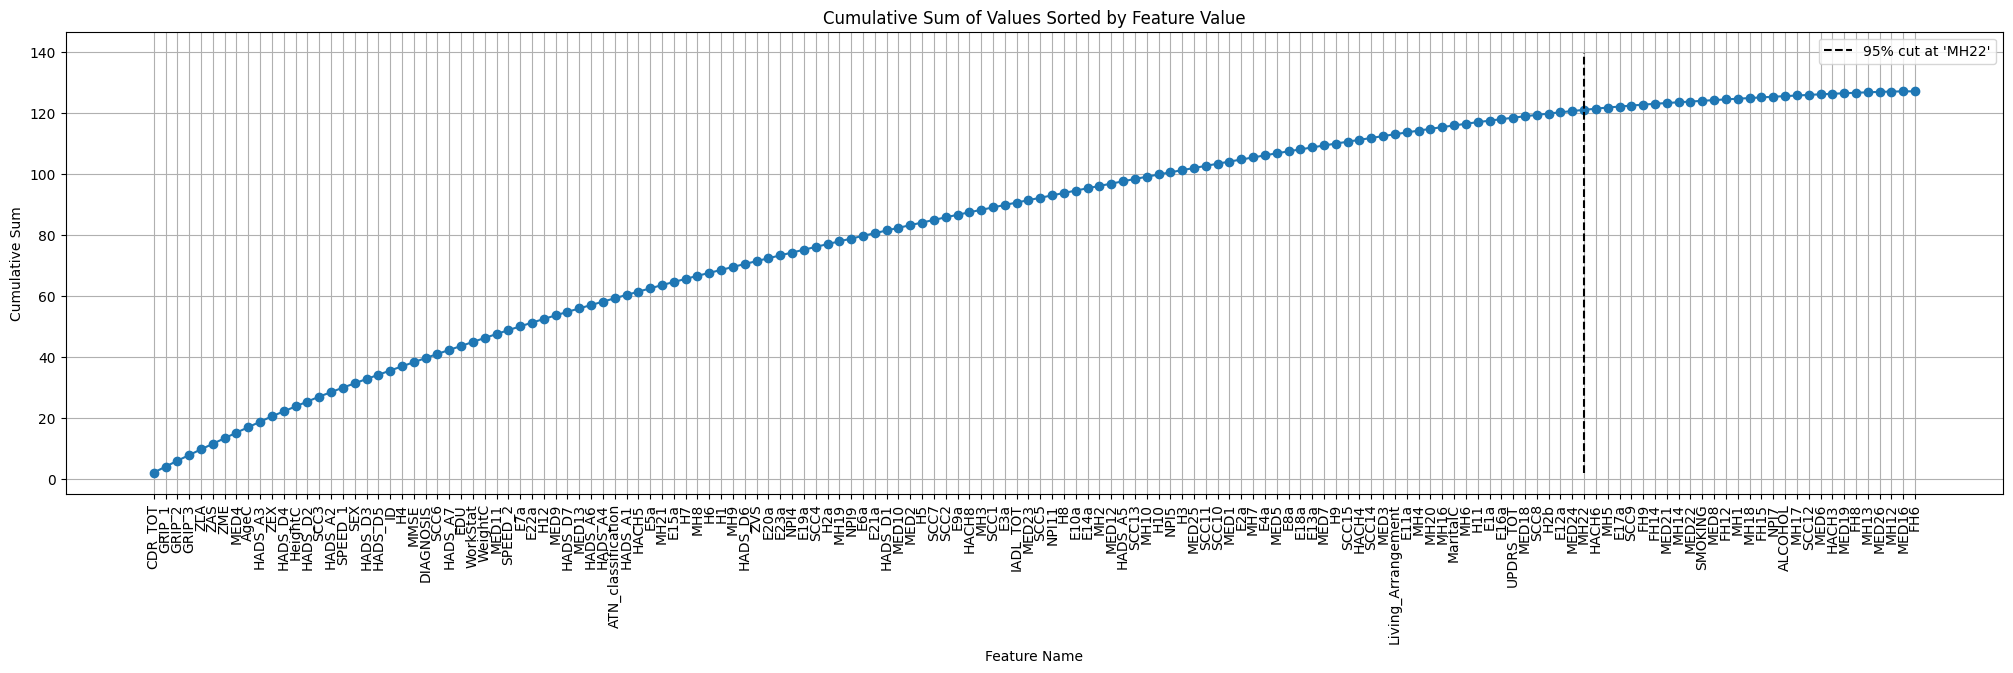

In [15]:
# Print the limit feature
print(f"\nLimit feature (where 95% cumulative sum is reached or fallback): {limit_feature}")

# Plotting
plt.figure(figsize=(25,6))
plt.plot(sorted_df['feature_name'], sorted_df['cumulative_sum'], marker='o')
plt.vlines(
    x=limit_feature,
    ymin=sorted_df['cumulative_sum'].min(),
    ymax=1.1 * sorted_df['cumulative_sum'].max(),
    label=f"95% cut at '{limit_feature}'",
    linestyles="dashed",
    color='black'
)
plt.xlabel('Feature Name')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values Sorted by Feature Value')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Remove unimportant features, in terms of mutual information and Spearman correlation
features_to_drop = filtered_df['feature_name'].tolist()

df = df.drop(columns=features_to_drop)
train_df = train_df.drop(columns=features_to_drop)
test_df = test_df.drop(columns=features_to_drop)

In [21]:
df = df.drop(columns=["GRIP_2", "GRIP_3", "E23a", "E1a", "H7", "E8a", "MH2", "SCC4"]) # Manually selected from the next step

corr_matrix = df.corr()

corr_unstacked = corr_matrix.unstack()

# Convert to a DataFrame and reset index
corr_df = pd.DataFrame(corr_unstacked, columns=['correlation']).reset_index()

# Rename the columns for better understanding
corr_df.columns = ['Variable_1', 'Variable_2', 'correlation']

# Remove self-correlations
corr_df = corr_df[corr_df['Variable_1'] != corr_df['Variable_2']]

# Drop duplicate pairs
corr_df['pair'] = corr_df.apply(lambda row: tuple(sorted([row['Variable_1'], row['Variable_2']])), axis=1)
corr_df = corr_df.drop_duplicates(subset=['pair'])

# Drop the 'pair' column as it's no longer needed
corr_df = corr_df.drop(columns=['pair'])

# Sort by correlation value in descending order
corr_df = corr_df.sort_values(by='correlation', ascending=False)


In [22]:
corr_df[corr_df['correlation'] > 0.85] 

Empty DataFrame
Columns: [Variable_1, Variable_2, correlation]
Index: []

In [24]:
# Removal of features with correlation > 0.85. Manually selected.
train_df = train_df.drop(columns=["GRIP_2", "GRIP_3", "E1a","E23a", "H7", "E8a", "MH2", "SCC4"])
test_df = test_df.drop(columns=["GRIP_2", "GRIP_3", "E1a","E23a", "H7", "E8a", "MH2", "SCC4"])

# Traind and Test Split

In [27]:
# Separate the ID for reference
train_ids = train_df['ID'].astype(str) + '_visit1'
test_ids = test_df['ID'].astype(str) + '_visit1'

# Define features and target variable for model training (excluding 'ID')
X_train = train_df.drop(columns=['DIAGNOSIS', 'ID'])
y_train = train_df['DIAGNOSIS']

X_test = test_df.drop(columns=['DIAGNOSIS', 'ID'])
y_test = test_df['DIAGNOSIS']

# Logistic Regression

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'C': np.float64(0.5532117123602399), 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validated Accuracy: 0.8402402402402404

Confusion Matrix:
[[28  3]
 [ 3 14]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        31
           1       0.82      0.82      0.82        17

    accuracy                           0.88        48
   macro avg       0.86      0.86      0.86        48
weighted avg       0.88      0.88      0.88        48

Matthews Correlation Coefficient (MCC): 0.7268

Feature Importance:
                Feature  Coefficient
26                MED12     0.636146
69                   H8     0.553282
27                MED13     0.449646
48              HADS_A1     0.332931
65                   H3     0.236143
106             SPEED_2     0.228112
84                 E13a     0.151697
32                 NPI4     0.147670
82 

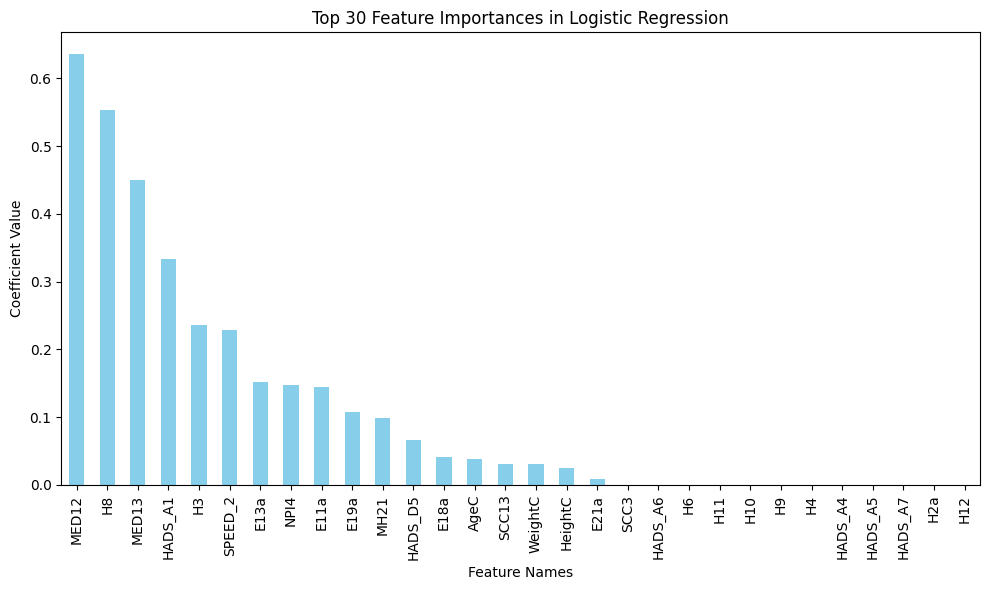

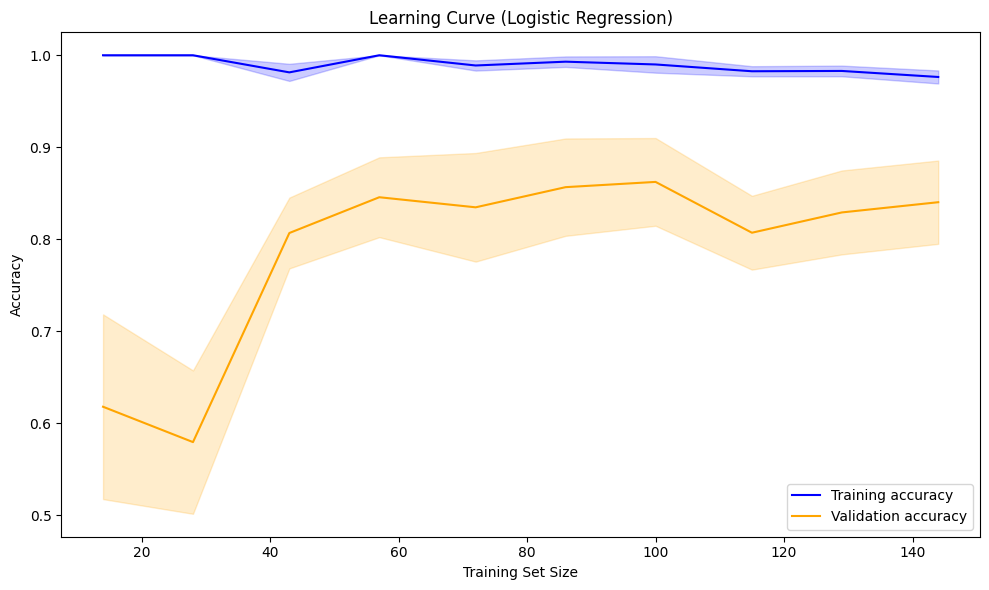

In [29]:
# Define the logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Define a randomized hyperparameter grid
param_distributions = {
    'C': uniform(0.001, 100),  # Continuous range for regularization strength
    'penalty': ['l1', 'l2'],   # Regularization type
    'solver': ['liblinear'],   # Solvers compatible with l1 and l2
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=logistic_model,
    param_distributions=param_distributions,
    n_iter=50,                 # Number of parameter settings to sample
    scoring='accuracy',        # Use accuracy as the evaluation metric
    cv=5,                      # 5-fold cross-validation
    verbose=1,                 # Print progress
    random_state=42,           # Ensure reproducibility
    n_jobs=-1                  # Use all available processors
)

# Perform hyperparameter tuning
random_search.fit(X_train, y_train)

# Print the best parameters and cross-validated accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validated Accuracy:", random_search.best_score_)

# Use the best model to make predictions
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the best model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate additional metrics
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
feature_importance[:30].set_index('Feature')['Coefficient'].plot(kind='bar', color='skyblue')
plt.title('Top 30 Feature Importances in Logistic Regression')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Generate the learning curve for Logistic Regression
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    random_state=42
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Logistic Regression)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# Logistic Regression + SMOTE

Class distribution after SMOTE:
DIAGNOSIS
0    113
1    113
Name: count, dtype: int64
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'C': np.float64(60.70442476866847), 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validated Accuracy: 0.8677294685990338

Confusion Matrix:
[[24  7]
 [ 2 15]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84        31
           1       0.68      0.88      0.77        17

    accuracy                           0.81        48
   macro avg       0.80      0.83      0.81        48
weighted avg       0.84      0.81      0.82        48

Matthews Correlation Coefficient (MCC): 0.6302

Feature Importance:
                Feature  Coefficient
16                 MH21     4.121207
27                MED13     3.775135
26                MED12     2.832852
48              HADS_A1     2.446369
32                 NPI4     2.151635
69                   H8     1

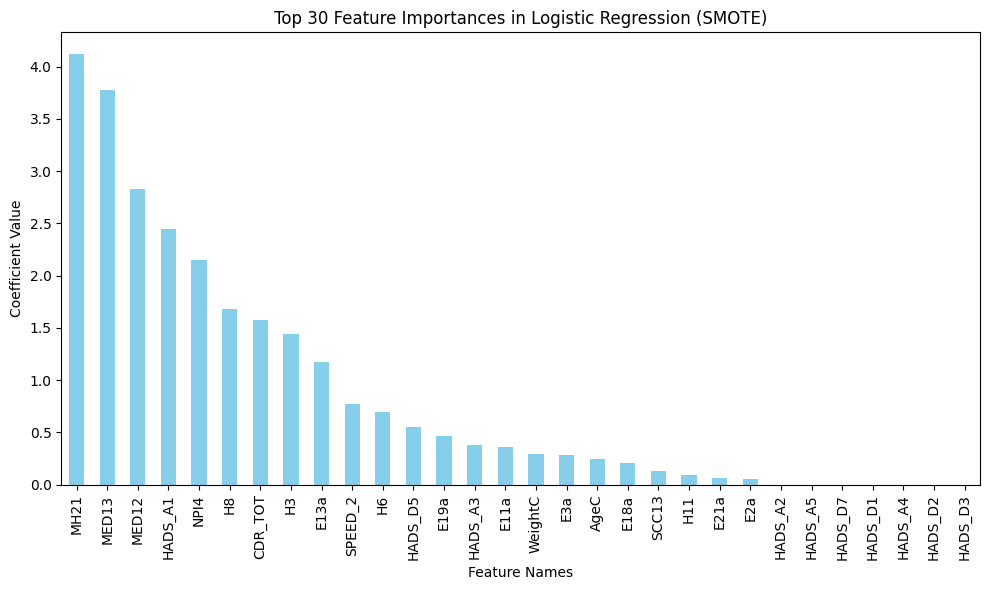

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/andyhuang/Desktop/dementia/e

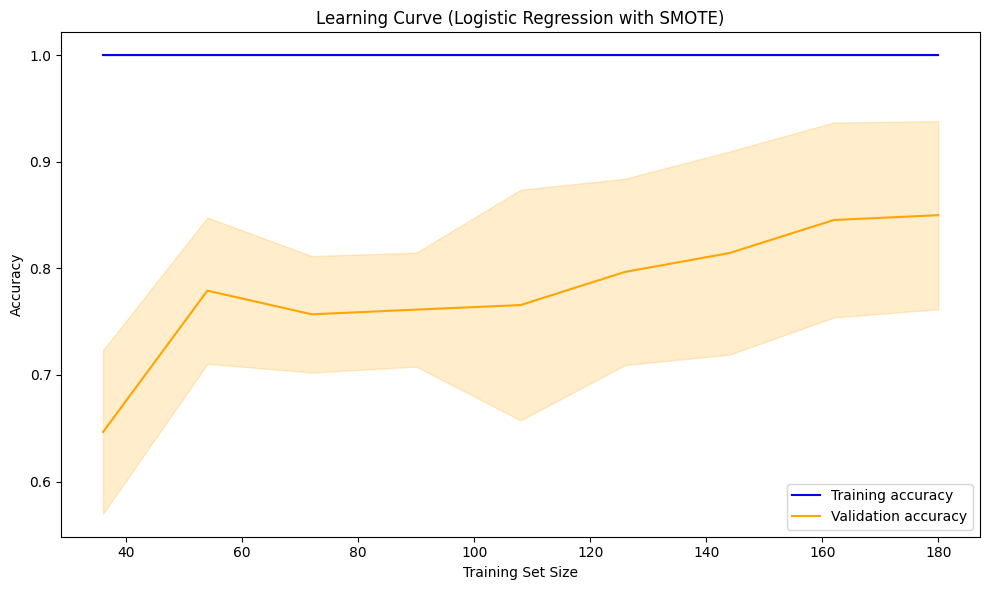

In [30]:
# Apply SMOTE 
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Define the logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Define a randomized hyperparameter grid
param_distributions = {
    'C': uniform(0.001, 100),  # Continuous range for regularization strength
    'penalty': ['l1', 'l2'],   # Regularization type
    'solver': ['liblinear'],   # Solvers compatible with l1 and l2
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=logistic_model,
    param_distributions=param_distributions,
    n_iter=50,                 # Number of parameter settings to sample
    scoring='accuracy',        # Use accuracy as the evaluation metric
    cv=5,                      # 5-fold cross-validation
    verbose=1,                 # Print progress
    random_state=42,           # Ensure reproducibility
    n_jobs=-1                  # Use all available processors
)

# Perform hyperparameter tuning
random_search.fit(X_train_smote, y_train_smote)

# Print the best parameters and cross-validated accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validated Accuracy:", random_search.best_score_)

# Use the best model to make predictions
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the best model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate additional metrics
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
feature_importance[:30].set_index('Feature')['Coefficient'].plot(kind='bar', color='skyblue')
plt.title('Top 30 Feature Importances in Logistic Regression (SMOTE)')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Generate the learning curve for Logistic Regression
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train_smote,
    y_train_smote,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    random_state=42
)

# Calculate means and standard deviations for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Logistic Regression with SMOTE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# Logistic Regression + RFE

Selected features: ['MH10', 'MH21', 'MED1', 'MED3', 'MED5', 'MED12', 'MED13', 'MED18', 'NPI11', 'CDR_TOT', 'HACH5', 'MMSE', 'ZME', 'ZEX', 'ZLA', 'HADS_A1', 'HADS_D4', 'HADS_D6', 'HADS_A7', 'H3', 'H5', 'H8', 'H9', 'H12', 'E4a', 'E7a', 'E10a', 'E11a', 'SCC5', 'SPEED_2']
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'C': np.float64(3.4398521115218395), 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validated Accuracy: 0.9282282282282281

Confusion Matrix:
[[27  4]
 [ 2 15]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        31
           1       0.79      0.88      0.83        17

    accuracy                           0.88        48
   macro avg       0.86      0.88      0.87        48
weighted avg       0.88      0.88      0.88        48

Matthews Correlation Coefficient (MCC): 0.7367

Feature Importance:
    Feature  Coefficient
9   CDR_TOT     1.777585
6     MED13     1

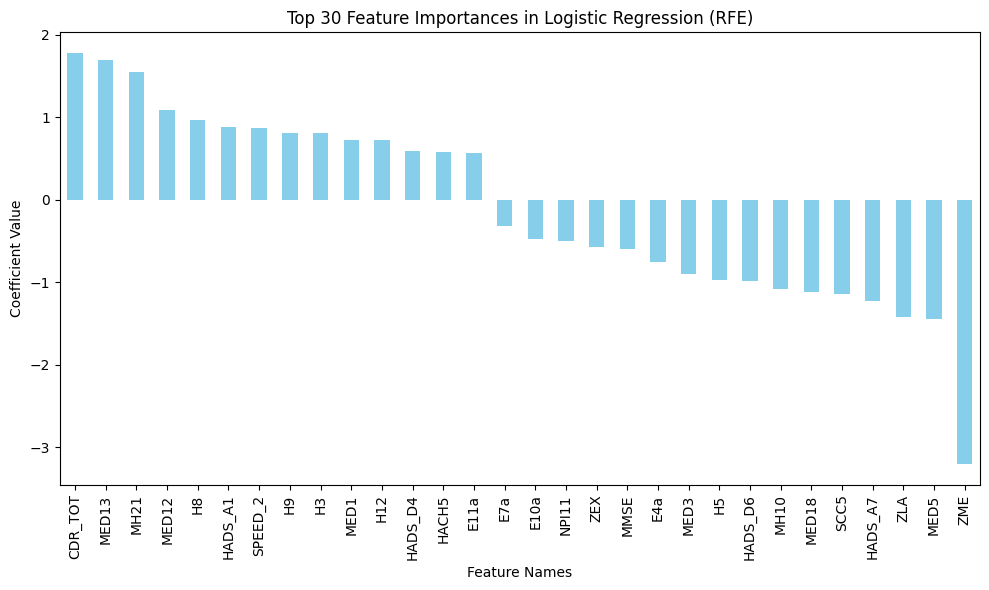

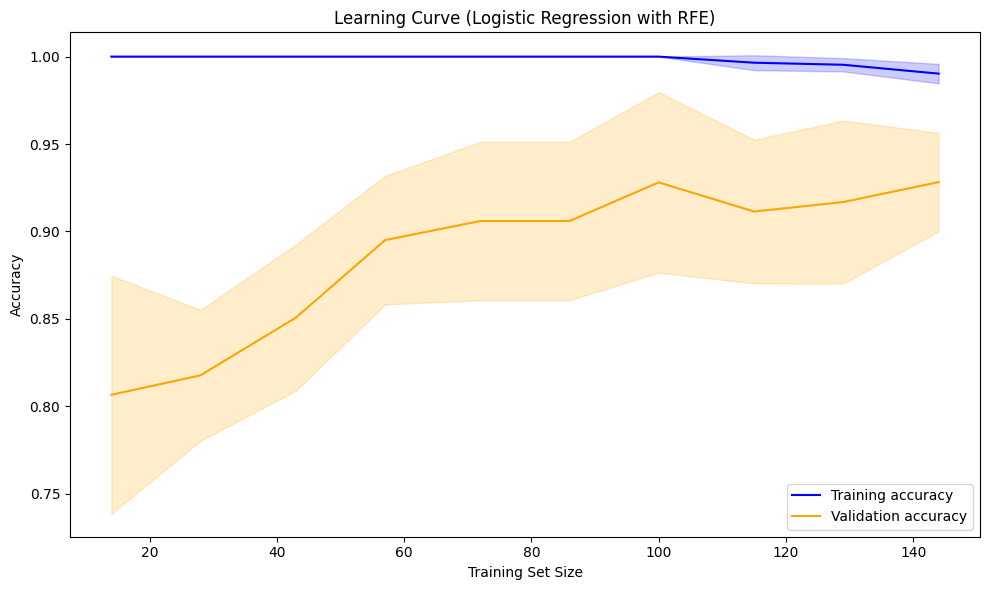

In [31]:
# Initialize logistic regression for RFE
logistic_rfe = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

# Perform RFE
rfe = RFE(estimator=logistic_rfe, n_features_to_select=30)  # Adjust `n_features_to_select` as needed
rfe.fit(X_train, y_train)

# Update training and test sets with selected features
X_train_rfe = X_train.iloc[:, rfe.support_]
X_test_rfe = X_test.iloc[:, rfe.support_]

print(f"Selected features: {list(X_train_rfe.columns)}")

# Define the logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Define a randomized hyperparameter grid
param_distributions = {
    'C': uniform(0.001, 100),  # Continuous range for regularization strength
    'penalty': ['l1', 'l2'],   # Regularization type
    'solver': ['liblinear'],   # Solvers compatible with l1 and l2
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=logistic_model,
    param_distributions=param_distributions,
    n_iter=50,                 # Number of parameter settings to sample
    scoring='accuracy',        # Use accuracy as the evaluation metric
    cv=5,                      # 5-fold cross-validation
    verbose=1,                 # Print progress
    random_state=42,           # Ensure reproducibility
    n_jobs=-1                  # Use all available processors
)

# Perform hyperparameter tuning
random_search.fit(X_train_rfe, y_train)

# Print the best parameters and cross-validated accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validated Accuracy:", random_search.best_score_)

# Use the best model to make predictions
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_rfe)

# Evaluate the best model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate additional metrics
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train_rfe.columns,
    'Coefficient': best_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
feature_importance[:30].set_index('Feature')['Coefficient'].plot(kind='bar', color='skyblue')
plt.title('Top 30 Feature Importances in Logistic Regression (RFE)')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Generate the learning curve for Logistic Regression
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train_rfe,
    y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    random_state=42
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Logistic Regression with RFE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# Logistic Regression + RFE + SMOTE

Class distribution after SMOTE:
DIAGNOSIS
0    113
1    113
Name: count, dtype: int64
Selected Features via RFE:
Index(['WorkStat', 'MH10', 'MH21', 'MED1', 'MED5', 'MED12', 'MED13', 'MED18',
       'NPI11', 'CDR_TOT', 'IADL_TOT', 'HACH5', 'ZME', 'ZEX', 'ZLA', 'HADS_A1',
       'HADS_D5', 'HADS_D6', 'HADS_A7', 'H3', 'H5', 'H8', 'E4a', 'E9a', 'E10a',
       'E11a', 'SCC5', 'SCC6', 'SCC14', 'SPEED_2'],
      dtype='object')
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'C': np.float64(0.07887658410143283), 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validated Accuracy: 0.9379710144927536

Confusion Matrix:
[[27  4]
 [ 2 15]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        31
           1       0.79      0.88      0.83        17

    accuracy                           0.88        48
   macro avg       0.86      0.88      0.87        48
weighted avg       0.88      0.88

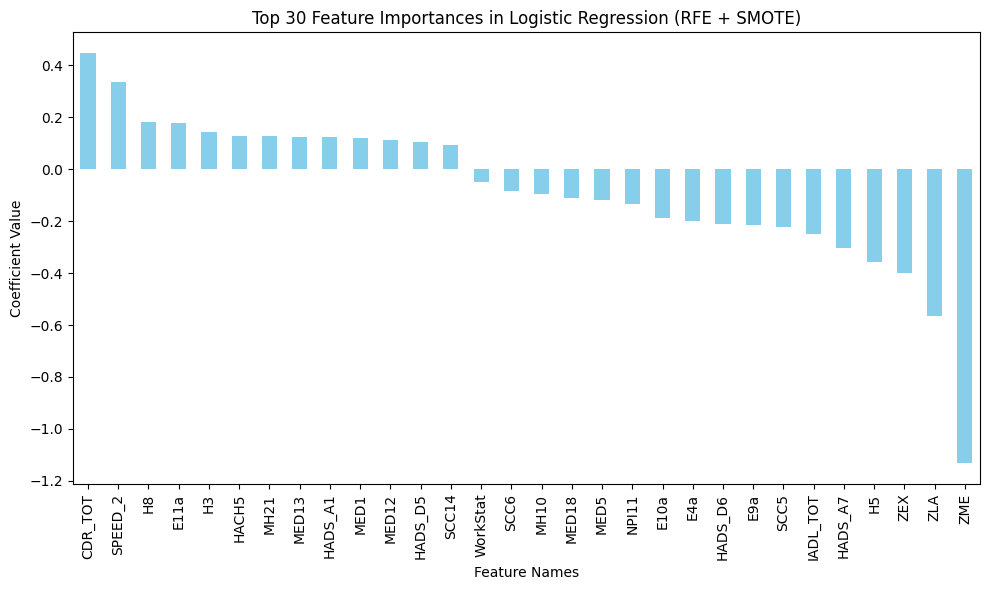

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/andyhuang/Desktop/dementia/e

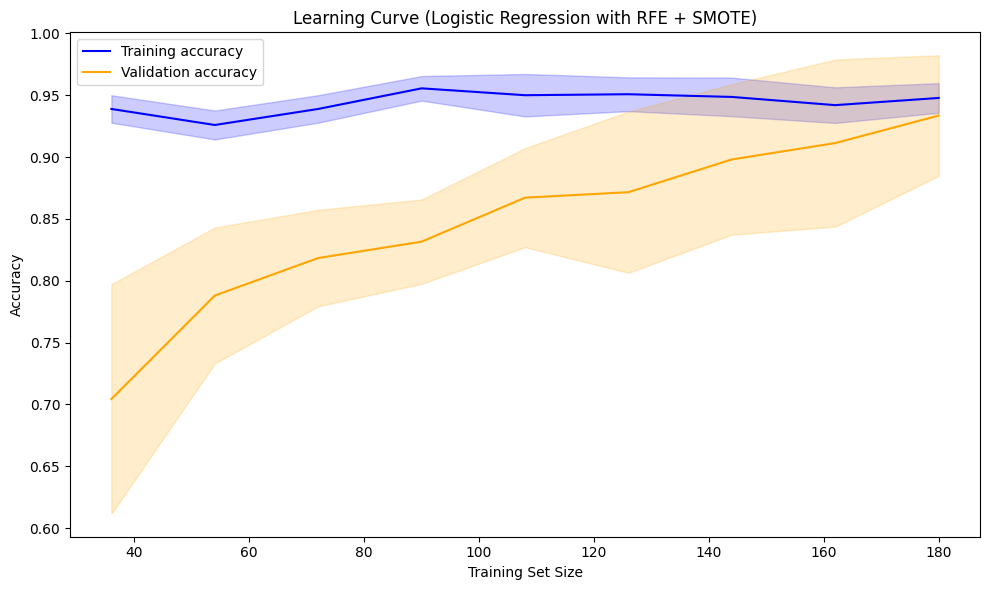

In [32]:
# Apply SMOTE 
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Define the logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Apply RFE 
rfe = RFE(estimator=logistic_model, n_features_to_select=30)  # Adjust the number of features to select
X_train_rfe = rfe.fit_transform(X_train_smote, y_train_smote)
X_test_rfe = rfe.transform(X_test)

# Print selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features via RFE:")
print(selected_features)

# Define a randomized hyperparameter grid
param_distributions = {
    'C': uniform(0.001, 100),  # Continuous range for regularization strength
    'penalty': ['l1', 'l2'],   # Regularization type
    'solver': ['liblinear'],   # Solvers compatible with l1 and l2
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=logistic_model,
    param_distributions=param_distributions,
    n_iter=50,                 # Number of parameter settings to sample
    scoring='accuracy',        # Use accuracy as the evaluation metric
    cv=5,                      # 5-fold cross-validation
    verbose=1,                 # Print progress
    random_state=42,           # Ensure reproducibility
    n_jobs=-1                  # Use all available processors
)

# Perform hyperparameter tuning
random_search.fit(X_train_rfe, y_train_smote)

# Print the best parameters and cross-validated accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validated Accuracy:", random_search.best_score_)

# Use the best model to make predictions
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_rfe)

# Evaluate the best model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate additional metrics
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': best_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
feature_importance[:30].set_index('Feature')['Coefficient'].plot(kind='bar', color='skyblue')
plt.title('Top 30 Feature Importances in Logistic Regression (RFE + SMOTE)')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Generate the learning curve for Logistic Regression
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train_rfe,
    y_train_smote,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    random_state=42
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Logistic Regression with RFE + SMOTE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# Decision Tree

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=15, min_samples_split=33; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Cross-validation scores: [0.89189189 0.80555556 0.83333333 0.80555556 0.97222222]
Mean cross-validation score: 0.8617117117117118
Cross-validation Accuracy: 0.861878453038674
Cross-validation MCC: 0.703394577212996
Cross-validation Confusion Matrix:
[[102  11]
 [ 14  54]]
Cross-validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       113
           1       0.83      0.79      0.81        68

    accuracy                           0.86       181
   macro avg       0.86      0.85      0.85       181
weighted avg       0.86      0.86      0.86       181

Test Set Accuracy: 0.875
Test Set MCC: 0.7367317724443136
Test Set Confusion Matrix:
[[27  4]
 [ 2 15]]
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        31
           1       0.79      0.88      0.83        17

    accuracy                           0.88        48
   mac

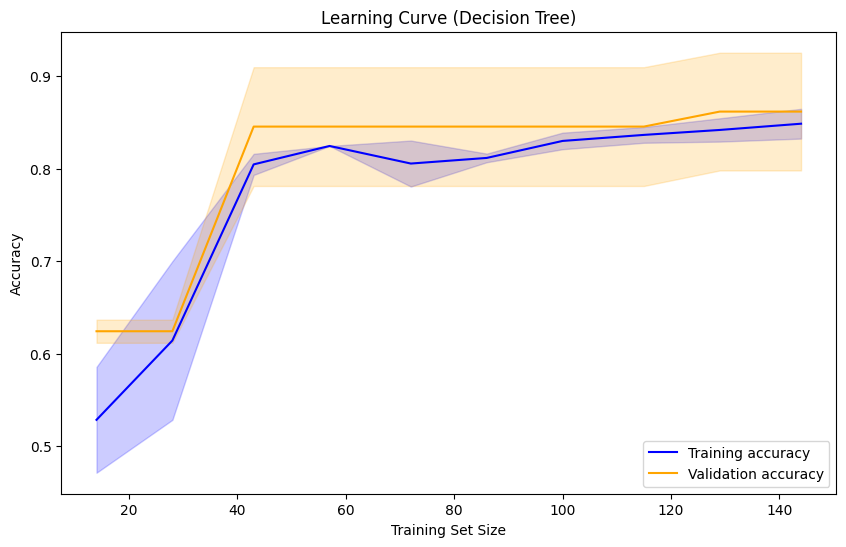

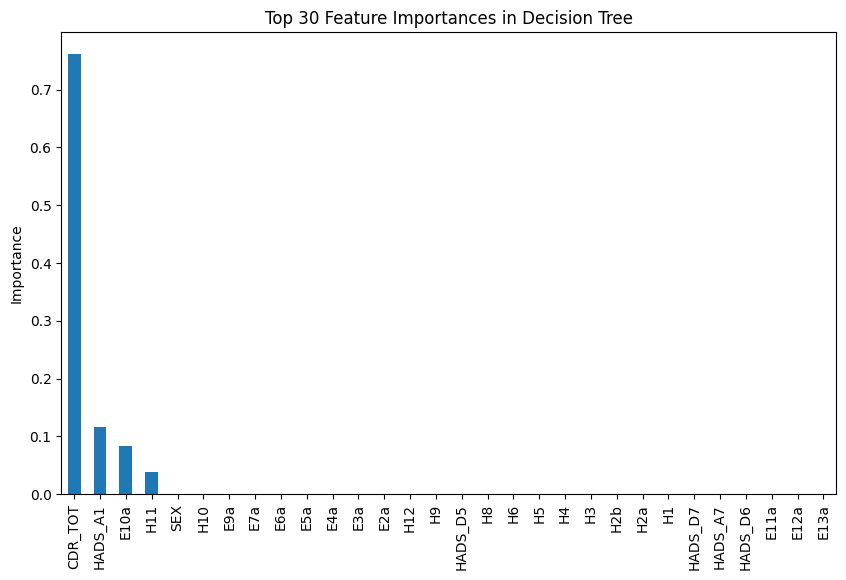

In [33]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],                  # Standard splitting criteria
    'max_depth': [3, 5, 7, 10],                       # Further reduce maximum depth
    'min_samples_split': randint(10, 50),             # Increase the minimum samples to split
    'min_samples_leaf': randint(5, 20),               # Increase the minimum samples in a leaf
    'max_features': ['sqrt', 'log2'],                 # Force splits to consider fewer features
    'max_leaf_nodes': [10, 20, 50],                   # Strongly limit the number of leaf nodes
    'min_impurity_decrease': [0.01, 0.05, 0.1]        # Increase minimum impurity decrease
}

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize RandomizedSearchCV
dt_random = RandomizedSearchCV(estimator=dt, param_distributions=param_grid,
                               n_iter=200, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the randomized search model
dt_random.fit(X_train, y_train)

# Get the best estimator
best_dt = dt_random.best_estimator_

# Perform cross-validation with the best estimator
cv_scores = cross_val_score(best_dt, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Cross-validation predictions
y_cv_pred = cross_val_predict(best_dt, X_train, y_train, cv=5)

# Evaluate cross-validation predictions
cv_accuracy = accuracy_score(y_train, y_cv_pred)
cv_conf_matrix = confusion_matrix(y_train, y_cv_pred)
cv_class_report = classification_report(y_train, y_cv_pred)
cv_mcc = matthews_corrcoef(y_train, y_cv_pred)

print(f"Cross-validation Accuracy: {cv_accuracy}")
print(f"Cross-validation MCC: {cv_mcc}")
print("Cross-validation Confusion Matrix:")
print(cv_conf_matrix)
print("Cross-validation Classification Report:")
print(cv_class_report)

# Train the best model on the full training data
best_dt.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_dt.predict(X_test)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
test_mcc = matthews_corrcoef(y_test, y_pred)

print(f"Test Set Accuracy: {accuracy}")
print(f"Test Set MCC: {test_mcc}")
print("Test Set Confusion Matrix:")
print(conf_matrix)
print("Test Set Classification Report:")
print(class_report)

# Calculate class-specific accuracy
class_specific_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_labels = np.unique(y_test)

for label, acc in zip(class_labels, class_specific_accuracy):
    print(f"Class {label}: {acc}")

# Plot learning curves to check for overfitting
train_sizes, train_scores, val_scores = learning_curve(
    best_dt, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Decision Tree)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Feature importance analysis
feature_importances = best_dt.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances = pd.Series(feature_importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(10, 6))
feat_importances[:30].plot(kind='bar')
plt.title('Top 30 Feature Importances in Decision Tree')
plt.ylabel('Importance')
plt.show()

# Decision Tree + SMOTE

Class distribution after SMOTE:
DIAGNOSIS
0    113
1    113
Name: count, dtype: int64
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=g

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


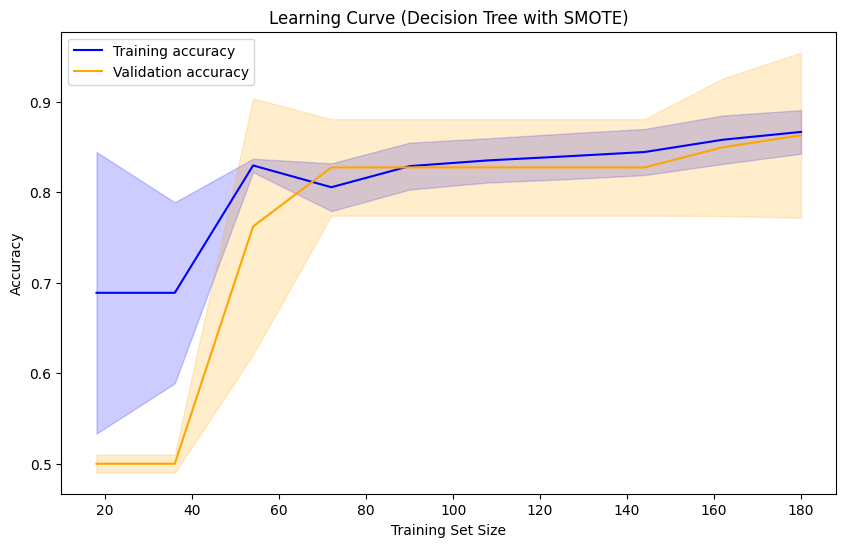

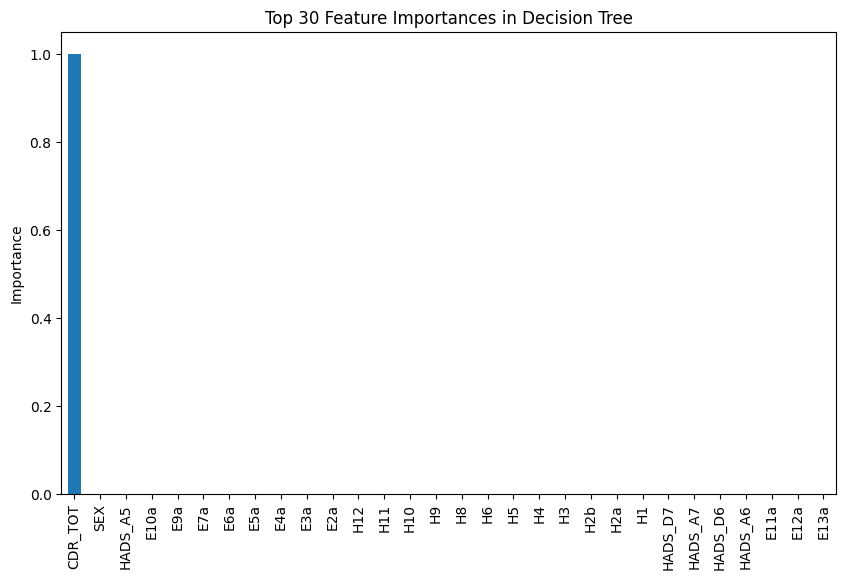

In [34]:
# Apply SMOTE 
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Define a parameter grid for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],                  # Standard splitting criteria
    'max_depth': [3, 5, 7, 10],                       # Further reduce maximum depth
    'min_samples_split': randint(10, 50),             # Increase the minimum samples to split
    'min_samples_leaf': randint(5, 20),               # Increase the minimum samples in a leaf
    'max_features': ['sqrt', 'log2'],                 # Force splits to consider fewer features
    'max_leaf_nodes': [10, 20, 50],                   # Strongly limit the number of leaf nodes
    'min_impurity_decrease': [0.01, 0.05, 0.1]        # Increase minimum impurity decrease
}

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize RandomizedSearchCV
dt_random = RandomizedSearchCV(estimator=dt, param_distributions=param_grid,
                               n_iter=200, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the randomized search model
dt_random.fit(X_train_smote, y_train_smote)

# Get the best estimator
best_dt = dt_random.best_estimator_

# Perform cross-validation with the best estimator
cv_scores = cross_val_score(best_dt, X_train_smote, y_train_smote, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Cross-validation predictions
y_cv_pred = cross_val_predict(best_dt, X_train_smote, y_train_smote, cv=5)

# Evaluate cross-validation predictions
cv_accuracy = accuracy_score(y_train_smote, y_cv_pred)
cv_conf_matrix = confusion_matrix(y_train_smote, y_cv_pred)
cv_class_report = classification_report(y_train_smote, y_cv_pred)
cv_mcc = matthews_corrcoef(y_train_smote, y_cv_pred)

print(f"Cross-validation Accuracy: {cv_accuracy}")
print("Cross-validation Confusion Matrix:")
print(cv_conf_matrix)
print("Cross-validation Classification Report:")
print(cv_class_report)
print(f"Cross-validation MCC: {cv_mcc}")

# Train the best model on the full training data (after SMOTE)
best_dt.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred = best_dt.predict(X_test)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Calculate class-specific accuracy
class_specific_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_labels = np.unique(y_test)

print(f"Test Set Accuracy: {accuracy}")
for label, acc in zip(class_labels, class_specific_accuracy):
    print(f"Class {label}: {acc}")
print("Test Set Confusion Matrix:")
print(conf_matrix)
print("Test Set Classification Report:")
print(class_report)
print(f"Test Set MCC: {mcc}")

# Plot learning curves to check for overfitting
train_sizes, train_scores, val_scores = learning_curve(
    best_dt, X_train_smote, y_train_smote, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Decision Tree with SMOTE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Feature importance analysis
feature_importances = best_dt.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances = pd.Series(feature_importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(10, 6))
feat_importances[:30].plot(kind='bar')
plt.title('Top 30 Feature Importances in Decision Tree')
plt.ylabel('Importance')
plt.show()


# Decision Tree + RFE

Selected Features via RFE:
Index(['EDU', 'AgeC', 'ΜaritalC', 'Living_Arrangement', 'WorkStat', 'MH3',
       'MH4', 'MH6', 'MH7', 'MH8', 'MH9', 'MH10', 'ZME', 'ZLA', 'H1', 'E6a',
       'E7a', 'E9a', 'E10a', 'E11a', 'E12a', 'E13a', 'E14a', 'E16a', 'E18a',
       'E20a', 'SPEED_1', 'SPEED_2', 'GRIP_1', 'WeightC'],
      dtype='object')
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.

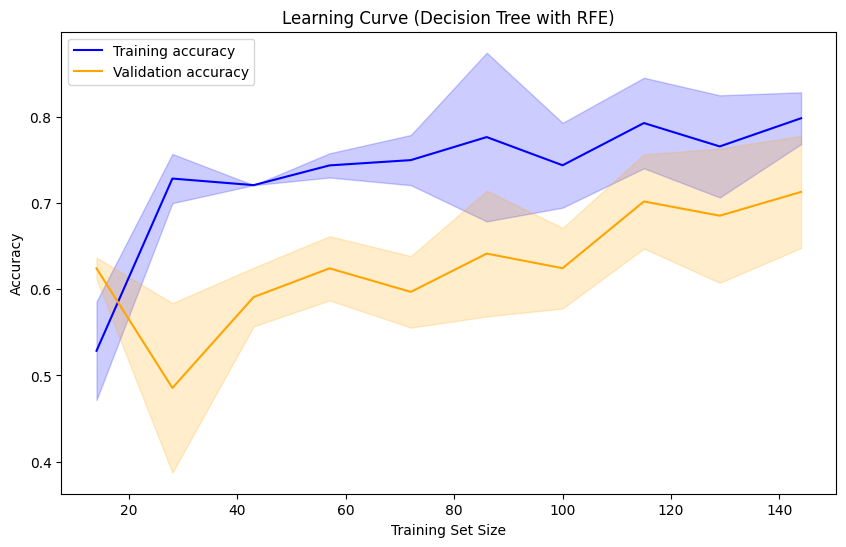

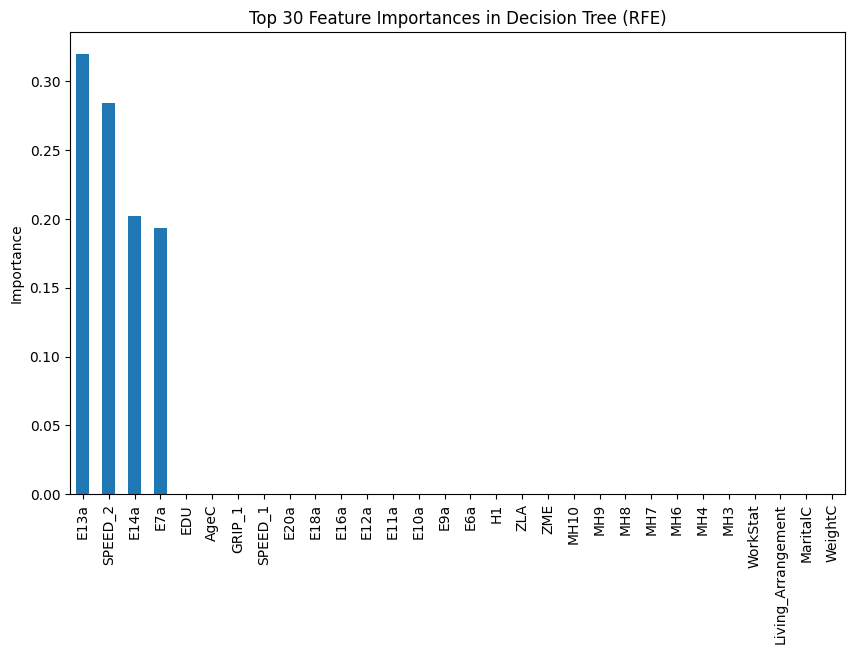

In [35]:
# Initialize the base Decision Tree model for RFE
base_dt = DecisionTreeClassifier(random_state=42)

# Apply RFE
rfe = RFE(estimator=base_dt, n_features_to_select=30)  # Adjust the number of features to select
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features via RFE:")
print(selected_features)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],                  # Standard splitting criteria
    'max_depth': [3, 5, 7, 10],                       # Further reduce maximum depth
    'min_samples_split': randint(10, 50),             # Increase the minimum samples to split
    'min_samples_leaf': randint(5, 20),               # Increase the minimum samples in a leaf
    'max_features': ['sqrt', 'log2'],                 # Force splits to consider fewer features
    'max_leaf_nodes': [10, 20, 50],                   # Strongly limit the number of leaf nodes
    'min_impurity_decrease': [0.01, 0.05, 0.1]        # Increase minimum impurity decrease
}

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize RandomizedSearchCV
dt_random = RandomizedSearchCV(estimator=dt, param_distributions=param_grid,
                               n_iter=200, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the randomized search model
dt_random.fit(X_train_rfe, y_train)

# Get the best estimator
best_dt = dt_random.best_estimator_

# Perform cross-validation with the best estimator
cv_scores = cross_val_score(best_dt, X_train_rfe, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Cross-validation predictions
y_cv_pred = cross_val_predict(best_dt, X_train_rfe, y_train, cv=5)

# Evaluate cross-validation predictions
cv_accuracy = accuracy_score(y_train, y_cv_pred)
cv_conf_matrix = confusion_matrix(y_train, y_cv_pred)
cv_class_report = classification_report(y_train, y_cv_pred)
cv_mcc = matthews_corrcoef(y_train, y_cv_pred)

print(f"Cross-validation Accuracy: {cv_accuracy}")
print(f"Cross-validation MCC: {cv_mcc}")
print("Cross-validation Confusion Matrix:")
print(cv_conf_matrix)
print("Cross-validation Classification Report:")
print(cv_class_report)

# Train the best model on the full training data (with RFE-selected features)
best_dt.fit(X_train_rfe, y_train)

# Make predictions on the test set (with RFE-selected features)
y_pred = best_dt.predict(X_test_rfe)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
test_mcc = matthews_corrcoef(y_test, y_pred)

print(f"Test Set Accuracy: {accuracy}")
print(f"Test Set MCC: {test_mcc}")
print("Test Set Confusion Matrix:")
print(conf_matrix)
print("Test Set Classification Report:")
print(class_report)

# Calculate class-specific accuracy
class_specific_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_labels = np.unique(y_test)

for label, acc in zip(class_labels, class_specific_accuracy):
    print(f"Class {label}: {acc}")

# Plot learning curves to check for overfitting
train_sizes, train_scores, val_scores = learning_curve(
    best_dt, X_train_rfe, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Decision Tree with RFE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Feature importance analysis
feature_importances = best_dt.feature_importances_
feat_importances = pd.Series(feature_importances, index=selected_features)
feat_importances = feat_importances.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(10, 6))
feat_importances[:30].plot(kind='bar')
plt.title('Top 30 Feature Importances in Decision Tree (RFE)')
plt.ylabel('Importance')
plt.show()


# Decision Tree + RFE + SMOTE

Class distribution after SMOTE:
DIAGNOSIS
0    113
1    113
Name: count, dtype: int64
Selected Features via RFE:
Index(['EDU', 'AgeC', 'ΜaritalC', 'Living_Arrangement', 'WorkStat', 'MH3',
       'MH4', 'MH6', 'MH7', 'MH8', 'MH9', 'MH16', 'MH19', 'ZME', 'H1', 'H2b',
       'H3', 'H4', 'H5', 'H6', 'H8', 'H9', 'H10', 'H11', 'H12', 'E2a', 'E3a',
       'E18a', 'SPEED_1', 'SPEED_2'],
      dtype='object')
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


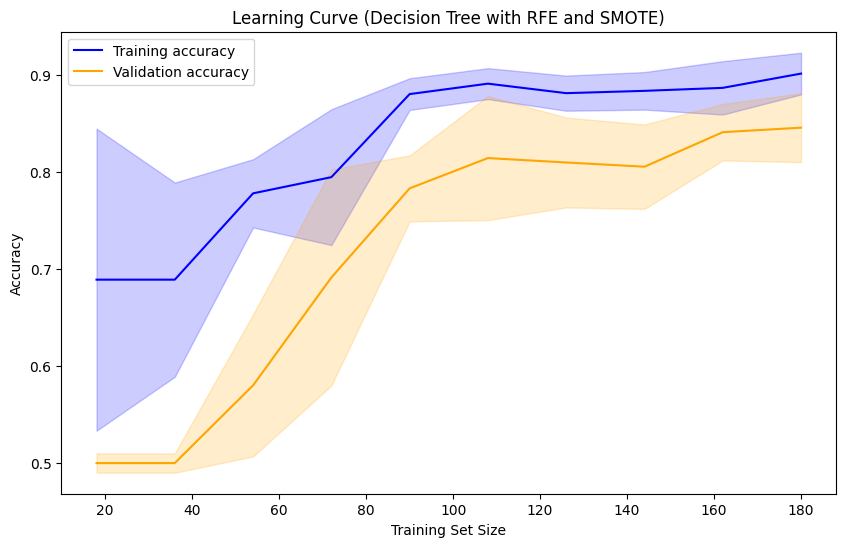

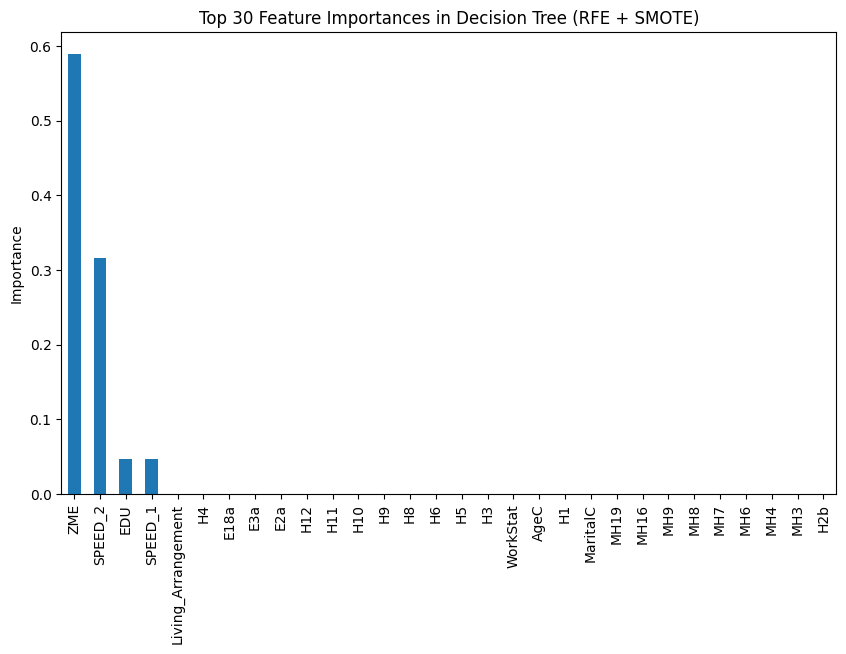

In [36]:
# Apply SMOTE 
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Initialize the base Decision Tree model for RFE
base_dt = DecisionTreeClassifier(random_state=42)

# Apply RFE
rfe = RFE(estimator=base_dt, n_features_to_select=30)  # Adjust the number of features to select
X_train_rfe = rfe.fit_transform(X_train_smote, y_train_smote)
X_test_rfe = rfe.transform(X_test)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features via RFE:")
print(selected_features)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],                  # Standard splitting criteria
    'max_depth': [3, 5, 7, 10],                       # Further reduce maximum depth
    'min_samples_split': randint(10, 50),             # Increase the minimum samples to split
    'min_samples_leaf': randint(5, 20),               # Increase the minimum samples in a leaf
    'max_features': ['sqrt', 'log2'],                 # Force splits to consider fewer features
    'max_leaf_nodes': [10, 20, 50],                   # Strongly limit the number of leaf nodes
    'min_impurity_decrease': [0.01, 0.05, 0.1]        # Increase minimum impurity decrease
}

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize RandomizedSearchCV
dt_random = RandomizedSearchCV(estimator=dt, param_distributions=param_grid,
                               n_iter=200, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the randomized search model
dt_random.fit(X_train_rfe, y_train_smote)

# Get the best estimator
best_dt = dt_random.best_estimator_

# Perform cross-validation with the best estimator
cv_scores = cross_val_score(best_dt, X_train_rfe, y_train_smote, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Cross-validation predictions
y_cv_pred = cross_val_predict(best_dt, X_train_rfe, y_train_smote, cv=5)

# Evaluate cross-validation predictions
cv_accuracy = accuracy_score(y_train_smote, y_cv_pred)
cv_conf_matrix = confusion_matrix(y_train_smote, y_cv_pred)
cv_class_report = classification_report(y_train_smote, y_cv_pred)
cv_mcc = matthews_corrcoef(y_train_smote, y_cv_pred)

print(f"Cross-validation Accuracy: {cv_accuracy}")
print(f"Cross-validation MCC: {cv_mcc}")
print("Cross-validation Confusion Matrix:")
print(cv_conf_matrix)
print("Cross-validation Classification Report:")
print(cv_class_report)

# Train the best model on the full training data (with RFE-selected features after SMOTE)
best_dt.fit(X_train_rfe, y_train_smote)

# Make predictions on the test set (with RFE-selected features)
y_pred = best_dt.predict(X_test_rfe)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
test_mcc = matthews_corrcoef(y_test, y_pred)

print(f"Test Set Accuracy: {accuracy}")
print(f"Test Set MCC: {test_mcc}")
print("Test Set Confusion Matrix:")
print(conf_matrix)
print("Test Set Classification Report:")
print(class_report)

# Calculate class-specific accuracy
class_specific_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_labels = np.unique(y_test)

for label, acc in zip(class_labels, class_specific_accuracy):
    print(f"Class {label}: {acc}")

# Plot learning curves to check for overfitting
train_sizes, train_scores, val_scores = learning_curve(
    best_dt, X_train_rfe, y_train_smote, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Decision Tree with RFE and SMOTE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Feature importance analysis
feature_importances = best_dt.feature_importances_
feat_importances = pd.Series(feature_importances, index=selected_features)
feat_importances = feat_importances.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(10, 6))
feat_importances[:30].plot(kind='bar')
plt.title('Top 30 Feature Importances in Decision Tree (RFE + SMOTE)')
plt.ylabel('Importance')
plt.show()


# Random Forest

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=25, max_features=sqrt, max_leaf_nodes=25, min_impurity_decrease=0.03, min_samples_leaf=6, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=15, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.02, min_samples_leaf=6, min_samples_split=35, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=15, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.02, min_samples_leaf=6, min_samples_split=35, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=15, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.02, min_samples_leaf=6, min_samples_split=35, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=15, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.0

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Cross-validation scores: [0.83783784 0.94444444 0.91666667 0.88888889 0.94444444]
Mean cross-validation score: 0.9064564564564564
Cross-validation Accuracy: 0.9060773480662984
Cross-validation Confusion Matrix:
[[109   4]
 [ 13  55]]
Cross-validation Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       113
           1       0.93      0.81      0.87        68

    accuracy                           0.91       181
   macro avg       0.91      0.89      0.90       181
weighted avg       0.91      0.91      0.90       181

Cross-validation MCC: 0.7991092006543676
Test Set Accuracy: 0.9166666666666666
Test Set Confusion Matrix:
[[29  2]
 [ 2 15]]
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        31
           1       0.88      0.88      0.88        17

    accuracy                           0.92        48
   macro avg       0.91 

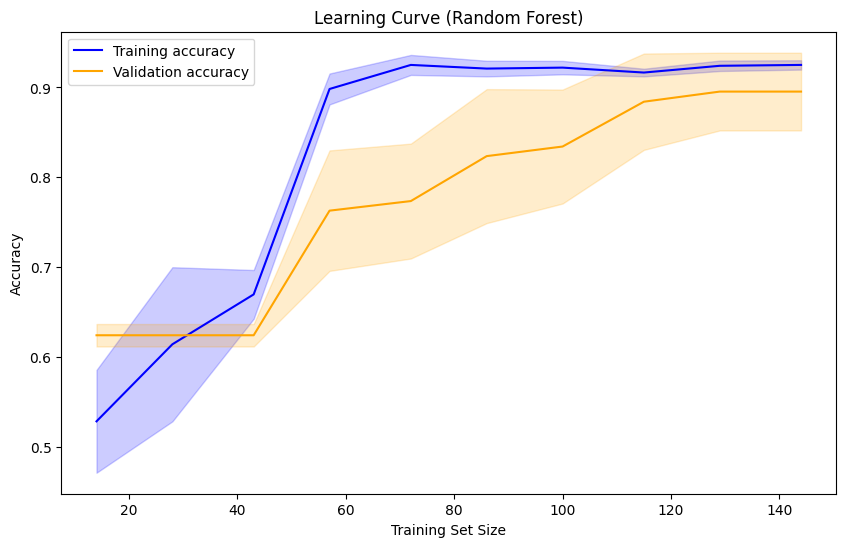

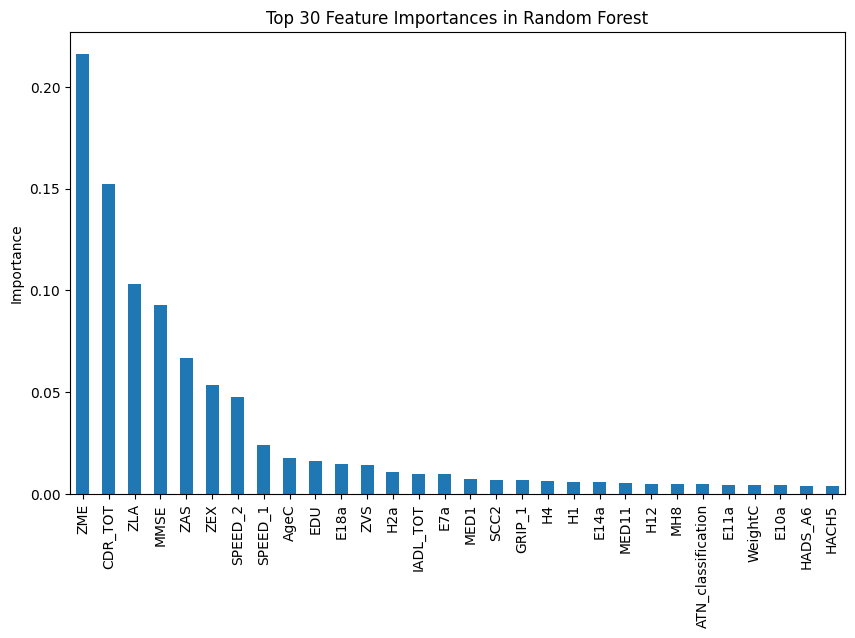

In [37]:
# Define a parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Stick with moderate numbers to reduce overfitting
    'max_features': ['sqrt'],  # Use simpler feature selection
    'max_depth': [10, 15, 20, 25],  # Control tree depth
    'min_samples_split': [15, 20, 25, 30, 35],  # Ensure nodes have enough samples to split
    'min_samples_leaf': [6, 8, 10, 12, 15],  # Enforce minimum leaf node sizes
    'bootstrap': [True],  # Keep bootstrap to maintain robustness
    'class_weight': [None, 'balanced'],  # Handle class imbalance if present
    'min_impurity_decrease': [0.01, 0.02, 0.03],  # Apply regularization to splits
    'max_leaf_nodes': [10, 15, 20, 25],  # Limit leaf nodes to prevent complex trees
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=0)

# Initialize RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                               n_iter=200, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the randomized search model
rf_random.fit(X_train, y_train)

# Get the best estimator
best_rf = rf_random.best_estimator_

# Perform cross-validation with the best estimator
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Cross-validation predictions
y_cv_pred = cross_val_predict(best_rf, X_train, y_train, cv=5)

# Evaluate cross-validation predictions
cv_accuracy = accuracy_score(y_train, y_cv_pred)
cv_conf_matrix = confusion_matrix(y_train, y_cv_pred)
cv_class_report = classification_report(y_train, y_cv_pred)
cv_mcc = matthews_corrcoef(y_train, y_cv_pred)

print(f"Cross-validation Accuracy: {cv_accuracy}")
print("Cross-validation Confusion Matrix:")
print(cv_conf_matrix)
print("Cross-validation Classification Report:")
print(cv_class_report)
print(f"Cross-validation MCC: {cv_mcc}")

# Train the best model on the full training data
best_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf.predict(X_test)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Calculate class-specific accuracy
class_specific_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_labels = np.unique(y_test)

print(f"Test Set Accuracy: {accuracy}")
print("Test Set Confusion Matrix:")
print(conf_matrix)
print("Test Set Classification Report:")
print(class_report)
for label, accuracy in zip(class_labels, class_specific_accuracy):
    print(f"Class {label}: {accuracy}")
print(f"Test Set MCC: {mcc}")

# Plot learning curves to check for overfitting
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=0
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Random Forest)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Feature importance analysis
feature_importances = best_rf.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances = pd.Series(feature_importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(10, 6))
feat_importances[:30].plot(kind='bar')
plt.title('Top 30 Feature Importances in Random Forest')
plt.ylabel('Importance')
plt.show()


# Random Forest + SMOTE

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=25, max_features=sqrt, max_leaf_nodes=25, min_impurity_decrease=0.03, min_samples_leaf=6, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=15, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.02, min_samples_leaf=6, min_samples_split=35, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=25, max_features=sqrt, max_leaf_nodes=25, min_impurity_decrease=0.03, min_samples_leaf=6, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=15, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.02, min_samples_leaf=6, min_samples_split=35, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=25, max_features=sqrt, max_leaf_nodes=25, min_impurity_decrea

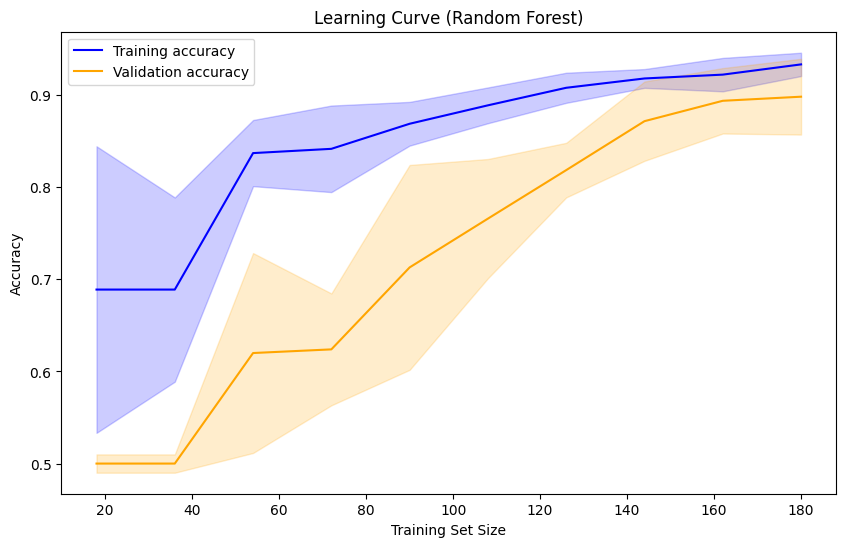

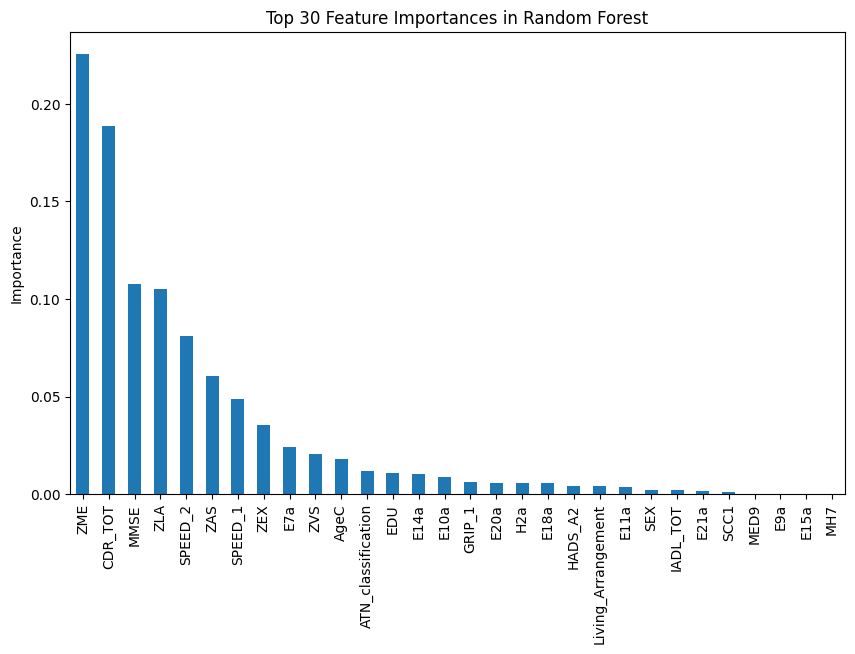

In [39]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Stick with moderate numbers to reduce overfitting
    'max_features': ['sqrt'],  # Use simpler feature selection
    'max_depth': [10, 15, 20, 25],  # Control tree depth
    'min_samples_split': [15, 20, 25, 30, 35],  # Ensure nodes have enough samples to split
    'min_samples_leaf': [6, 8, 10, 12, 15],  # Enforce minimum leaf node sizes
    'bootstrap': [True],  # Keep bootstrap to maintain robustness
    'class_weight': [None, 'balanced'],  # Handle class imbalance if present
    'min_impurity_decrease': [0.01, 0.02, 0.03],  # Apply regularization to splits
    'max_leaf_nodes': [10, 15, 20, 25],  # Limit leaf nodes to prevent complex trees
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=0)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV to the resampled training data
random_search.fit(X_train_res, y_train_res)

# Get the best parameters from RandomizedSearchCV
best_params = random_search.best_params_
print(f"Best Parameters from Randomized Search: {best_params}")

# Train the best model on the resampled training data
best_rf = random_search.best_estimator_

# Perform cross-validation on the resampled training data with the best model
cv_scores = cross_val_score(best_rf, X_train_res, y_train_res, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Cross-validation predictions on the resampled training data
y_cv_pred = cross_val_predict(best_rf, X_train_res, y_train_res, cv=5)

# Evaluate cross-validation predictions
cv_accuracy = accuracy_score(y_train_res, y_cv_pred)
cv_conf_matrix = confusion_matrix(y_train_res, y_cv_pred)
cv_class_report = classification_report(y_train_res, y_cv_pred)
cv_mcc = matthews_corrcoef(y_train_res, y_cv_pred)

print(f"Cross-validation Accuracy: {cv_accuracy}")
print("Cross-validation Confusion Matrix:")
print(cv_conf_matrix)
print("Cross-validation Classification Report:")
print(cv_class_report)
print(f"Cross-validation MCC: {cv_mcc}")

# Train the best model on the resampled training data
best_rf.fit(X_train_res, y_train_res)

# Make predictions on the test set
y_pred = best_rf.predict(X_test)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Calculate class-specific accuracy
class_specific_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_labels = np.unique(y_test)

print(f"Test Set Accuracy: {accuracy}")
print("Test Set Confusion Matrix:")
print(conf_matrix)
print("Test Set Classification Report:")
print(class_report)
print("Class-Specific Accuracy:")
for label, accuracy in zip(class_labels, class_specific_accuracy):
    print(f"Class {label}: {accuracy}")
print(f"Test Set MCC: {mcc}")

# Plot learning curves to check for overfitting
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train_res, y_train_res, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=0
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Random Forest)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Feature importance analysis
feature_importances = best_rf.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances = pd.Series(feature_importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(10, 6))
feat_importances[:30].plot(kind='bar')
plt.title('Top 30 Feature Importances in Random Forest')
plt.ylabel('Importance')
plt.show()


# Random Forest + RFE 

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=25, max_features=sqrt, max_leaf_nodes=25, min_impurity_decrease=0.03, min_samples_leaf=6, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=15, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.02, min_samples_leaf=6, min_samples_split=35, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=25, max_features=sqrt, max_leaf_nodes=25, min_impurity_decrease=0.03, min_samples_leaf=6, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=15, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.02, min_samples_leaf=6, min_samples_split=35, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=25, max_features=sqrt, max_leaf_nodes=25, min_impurity_decrea

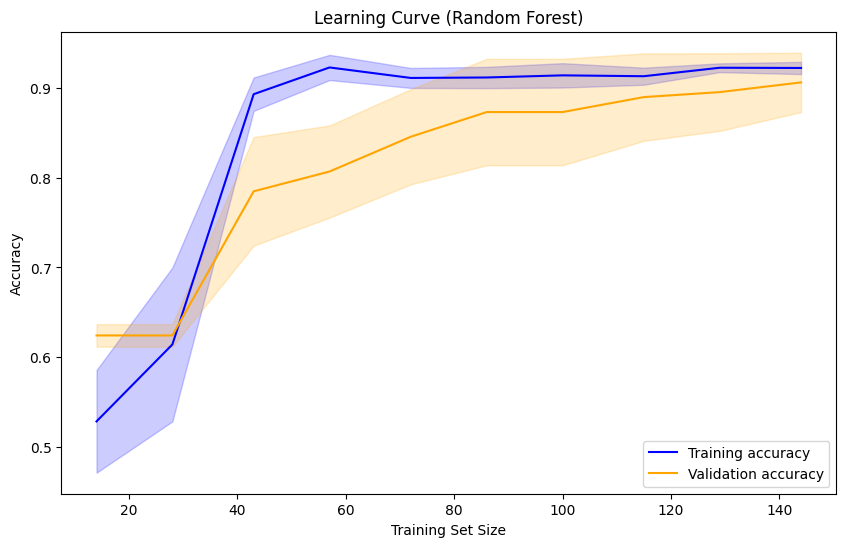

Test Set Accuracy: 0.9166666666666666
Test Set Confusion Matrix:
[[29  2]
 [ 2 15]]
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        31
           1       0.88      0.88      0.88        17

    accuracy                           0.92        48
   macro avg       0.91      0.91      0.91        48
weighted avg       0.92      0.92      0.92        48

Class-Specific Accuracy:
Class 0: 0.9354838709677419
Class 1: 0.8823529411764706
Test Set MCC: 0.8178368121442126


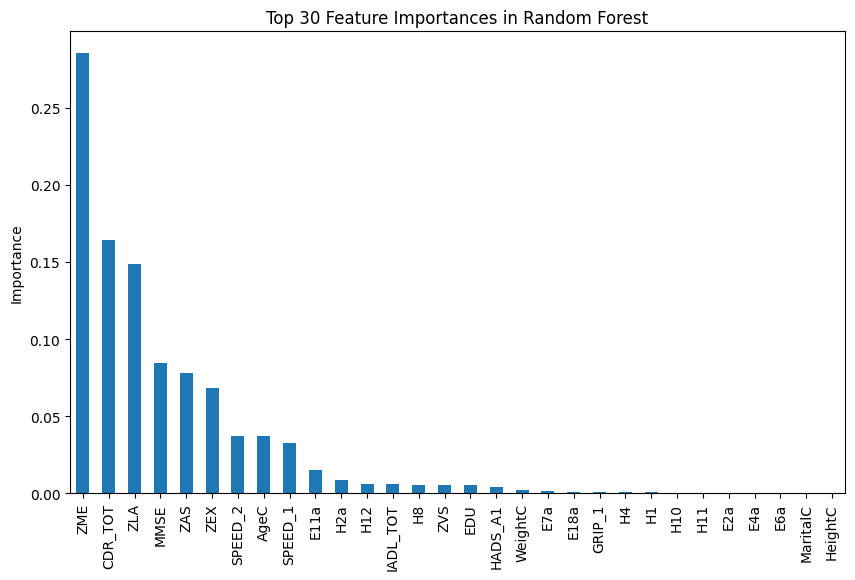

In [40]:
# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=0)

# Apply RFE
rfe = RFE(estimator=rf, n_features_to_select=30)  # Adjust n_features_to_select as needed
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)  # Apply the same feature selection to the test data

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Stick with moderate numbers to reduce overfitting
    'max_features': ['sqrt'],  # Use simpler feature selection
    'max_depth': [10, 15, 20, 25],  # Control tree depth
    'min_samples_split': [15, 20, 25, 30, 35],  # Ensure nodes have enough samples to split
    'min_samples_leaf': [6, 8, 10, 12, 15],  # Enforce minimum leaf node sizes
    'bootstrap': [True],  # Keep bootstrap to maintain robustness
    'class_weight': [None, 'balanced'],  # Handle class imbalance if present
    'min_impurity_decrease': [0.01, 0.02, 0.03],  # Apply regularization to splits
    'max_leaf_nodes': [10, 15, 20, 25],  # Limit leaf nodes to prevent complex trees
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV to the RFE-transformed training data
random_search.fit(X_train_rfe, y_train)

# Get the best parameters from RandomizedSearchCV
best_params = random_search.best_params_
print(f"Best Parameters from Randomized Search: {best_params}")

# Train the best model on the RFE-transformed training data
best_rf = random_search.best_estimator_

# Perform cross-validation on the original training data with the best model
cv_scores = cross_val_score(best_rf, X_train_rfe, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Cross-validation predictions on the RFE-transformed training data
y_cv_pred = cross_val_predict(best_rf, X_train_rfe, y_train, cv=5)

# Evaluate cross-validation predictions
cv_accuracy = accuracy_score(y_train, y_cv_pred)
cv_conf_matrix = confusion_matrix(y_train, y_cv_pred)
cv_class_report = classification_report(y_train, y_cv_pred)
cv_mcc = matthews_corrcoef(y_train, y_cv_pred)


print(f"Cross-validation Accuracy: {cv_accuracy}")
print("Cross-validation Confusion Matrix:")
print(cv_conf_matrix)
print("Cross-validation Classification Report:")
print(cv_class_report)
print(f"Cross-validation MCC: {cv_mcc}")

# Train the best model on the RFE-transformed training data
best_rf.fit(X_train_rfe, y_train)

# Plot learning curves to assess potential overfitting
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train_rfe, y_train, cv=5, scoring='accuracy', 
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Random Forest)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Make predictions on the RFE-transformed test set
y_pred = best_rf.predict(X_test_rfe)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Calculate class-specific accuracy
class_specific_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_labels = np.unique(y_test)

print(f"Test Set Accuracy: {accuracy}")
print("Test Set Confusion Matrix:")
print(conf_matrix)
print("Test Set Classification Report:")
print(class_report)
print("Class-Specific Accuracy:")
for label, accuracy in zip(class_labels, class_specific_accuracy):
    print(f"Class {label}: {accuracy}")
print(f"Test Set MCC: {mcc}")

# Feature importance analysis
feature_importances = best_rf.feature_importances_
feature_names = X_train.columns[rfe.get_support()]  # Only include selected features
feat_importances = pd.Series(feature_importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(10, 6))
feat_importances[:30].plot(kind='bar')
plt.title('Top 30 Feature Importances in Random Forest')
plt.ylabel('Importance')
plt.show()


# Random Forest + RFE + SMOTE

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, class_weight=None, max_depth=15, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.02, min_samples_leaf=6, min_samples_split=35, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=25, max_features=sqrt, max_leaf_nodes=25, min_impurity_decrease=0.03, min_samples_leaf=6, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=15, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.02, min_samples_leaf=6, min_samples_split=35, n_estimators=150; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=25, max_features=sqrt, max_leaf_nodes=25, min_impurity_decrease=0.03, min_samples_leaf=6, min_samples_split=20, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=15, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0

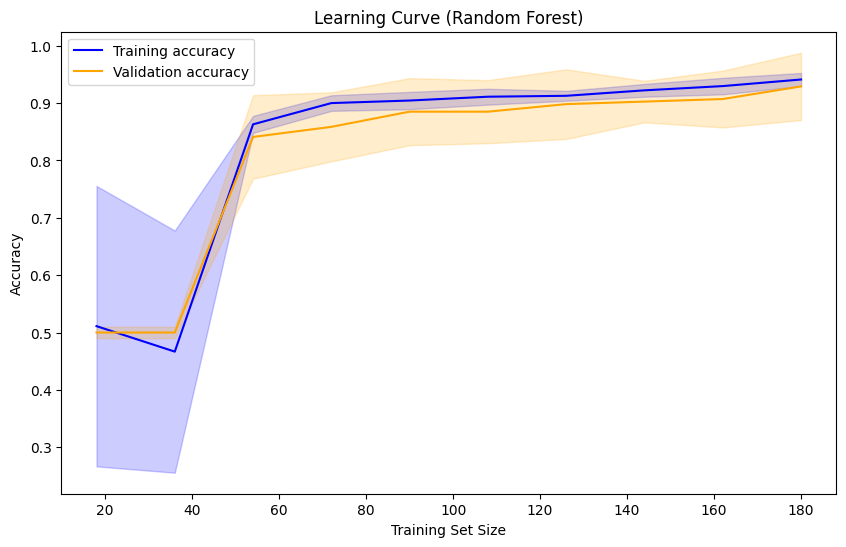

Test Set Accuracy: 0.875
Test Set Confusion Matrix:
[[26  5]
 [ 1 16]]
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90        31
           1       0.76      0.94      0.84        17

    accuracy                           0.88        48
   macro avg       0.86      0.89      0.87        48
weighted avg       0.89      0.88      0.88        48

Class-Specific Accuracy:
Class 0: 0.8387096774193549
Class 1: 0.9411764705882353
Test Set MCC: 0.7518738576131742


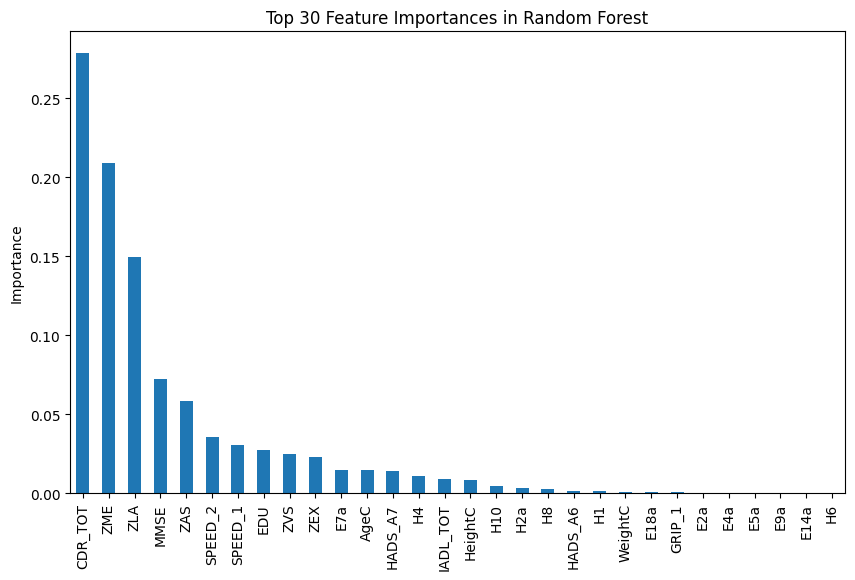

In [41]:
# Apply SMOTE 
smote = SMOTE(random_state=42)  # Adjusted SMOTE parameters
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=0)

# Apply RFE
rfe = RFE(estimator=rf, n_features_to_select=30)  # Adjust n_features_to_select as needed
X_train_res_rfe = rfe.fit_transform(X_train_res, y_train_res)
X_test_rfe = rfe.transform(X_test)  # Apply the same feature selection to the test data

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Stick with moderate numbers to reduce overfitting
    'max_features': ['sqrt'],  # Use simpler feature selection
    'max_depth': [10, 15, 20, 25],  # Control tree depth
    'min_samples_split': [15, 20, 25, 30, 35],  # Ensure nodes have enough samples to split
    'min_samples_leaf': [6, 8, 10, 12, 15],  # Enforce minimum leaf node sizes
    'bootstrap': [True],  # Keep bootstrap to maintain robustness
    'class_weight': [None, 'balanced'],  # Handle class imbalance if present
    'min_impurity_decrease': [0.01, 0.02, 0.03],  # Apply regularization to splits
    'max_leaf_nodes': [10, 15, 20, 25],  # Limit leaf nodes to prevent complex trees
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV to the resampled and RFE-transformed training data
random_search.fit(X_train_res_rfe, y_train_res)

# Get the best parameters from RandomizedSearchCV
best_params = random_search.best_params_
print(f"Best Parameters from Randomized Search: {best_params}")

# Train the best model on the resampled and RFE-transformed training data
best_rf = random_search.best_estimator_

# Perform cross-validation on the resampled training data with the best model
cv_scores = cross_val_score(best_rf, X_train_res_rfe, y_train_res, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Cross-validation predictions on the resampled and RFE-transformed training data
y_cv_pred = cross_val_predict(best_rf, X_train_res_rfe, y_train_res, cv=5)

# Evaluate cross-validation predictions
cv_accuracy = accuracy_score(y_train_res, y_cv_pred)
cv_conf_matrix = confusion_matrix(y_train_res, y_cv_pred)
cv_class_report = classification_report(y_train_res, y_cv_pred)
cv_mcc = matthews_corrcoef(y_train_res, y_cv_pred)


print(f"Cross-validation Accuracy: {cv_accuracy}")
print("Cross-validation Confusion Matrix:")
print(cv_conf_matrix)
print("Cross-validation Classification Report:")
print(cv_class_report)
print(f"Cross-validation MCC: {cv_mcc}")

# Train the best model on the resampled and RFE-transformed training data
best_rf.fit(X_train_res_rfe, y_train_res)

# Plot learning curves to assess potential overfitting
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train_res_rfe, y_train_res, cv=5, scoring='accuracy', 
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Random Forest)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Make predictions on the RFE-transformed test set
y_pred = best_rf.predict(X_test_rfe)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Calculate class-specific accuracy
class_specific_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_labels = np.unique(y_test)

print(f"Test Set Accuracy: {accuracy}")
print("Test Set Confusion Matrix:")
print(conf_matrix)
print("Test Set Classification Report:")
print(class_report)
print("Class-Specific Accuracy:")
for label, accuracy in zip(class_labels, class_specific_accuracy):
    print(f"Class {label}: {accuracy}")
print(f"Test Set MCC: {mcc}")

# Feature importance analysis
feature_importances = best_rf.feature_importances_
feature_names = X_train.columns[rfe.get_support()]  # Only include selected features
feat_importances = pd.Series(feature_importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(10, 6))
feat_importances[:30].plot(kind='bar')
plt.title('Top 30 Feature Importances in Random Forest')
plt.ylabel('Importance')
plt.show()


# LightGBM

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:                   
[22]	cv_agg's valid binary_logloss: 0.324715 + 0.0438677
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:                                             
[32]	cv_agg's valid binary_logloss: 0.343001 + 0.0388951
Training until validation scores don't improve for 10 rounds                   
Early stopping, best iteration is:                                             
[28]	cv_agg's valid binary_logloss: 0.323814 + 0.0532788
Training until validation scores don't improve for 10 rounds                    
Did not meet early stopping. Best iteration is:                                 
[100]	cv_agg's valid binary_logloss: 0.356672 + 0.0309494
Training until validation scores don't improve for 10 rounds                    
Early stopping, best iteration is:                                              
[53]	cv_agg's valid binary_logl

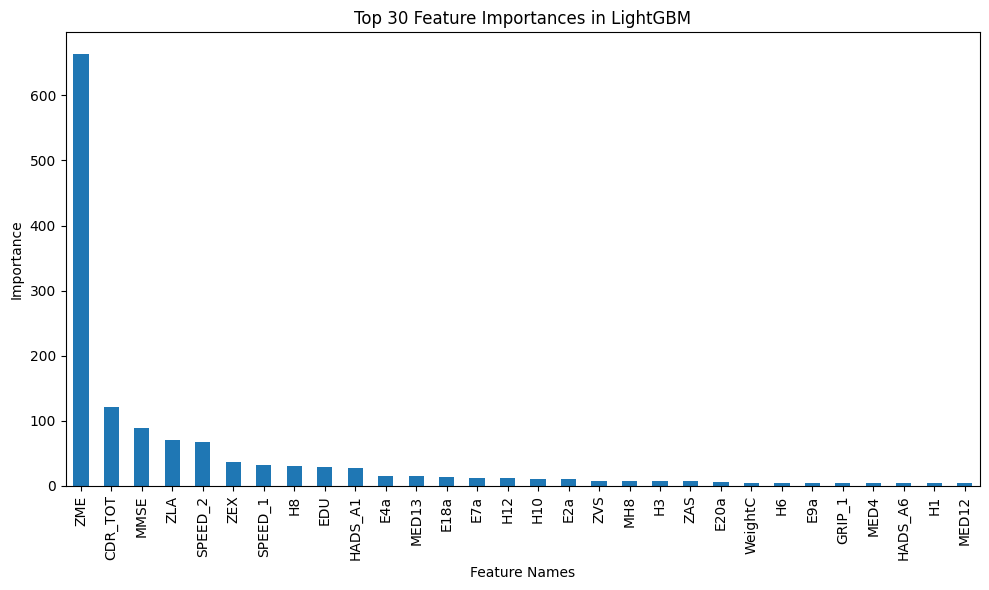

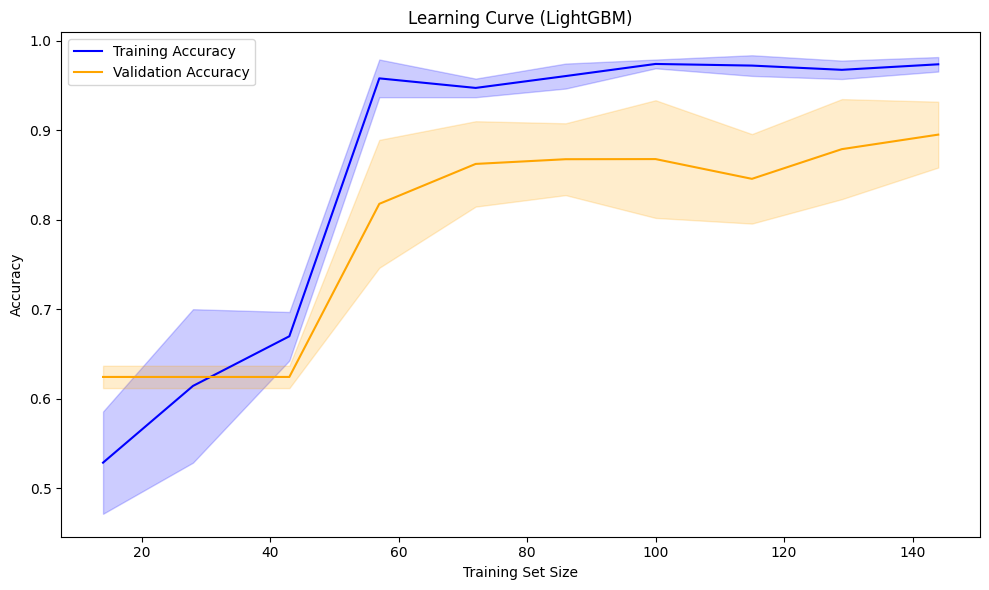

In [42]:
# Define the search space for Hyperopt
space = {
    'num_leaves': scope.int(hp.quniform('num_leaves', 10, 120, 1)),
    'learning_rate': hp.loguniform('learning_rate', -4.5, -1),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 0.9),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 0.9),
    'bagging_freq': scope.int(hp.quniform('bagging_freq', 1, 8, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 30, 1)),
    'lambda_l1': hp.loguniform('lambda_l1', -5, 0),
    'lambda_l2': hp.loguniform('lambda_l2', -5, 0),
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0, 1),
    'num_boost_round': scope.int(hp.quniform('num_boost_round', 50, 300, 10)),
    'verbose': -1,
    'random_state': random_seed
}

# Prepare LightGBM datasets
d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_test, label=y_test, reference=d_train)

# Define the objective function for Hyperopt
def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    num_boost_round = int(params['num_boost_round'])
    del params['num_boost_round']
    
    cv_results = lgb.cv(
        params,
        d_train,
        num_boost_round=num_boost_round,
        nfold=5,
        stratified=True,
        shuffle=True,
        seed=random_seed,
        metrics='binary_logloss',
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )
    
    logloss_key = 'binary_logloss-mean' if 'binary_logloss-mean' in cv_results else list(cv_results.keys())[0]
    return min(cv_results[logloss_key])

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=8, trials=trials, rstate=np.random.default_rng(random_seed))
print(f"Best hyperparameters: {best}")

# Use the best hyperparameters to train the final model
best_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': int(best['num_leaves']),
    'learning_rate': best['learning_rate'],
    'feature_fraction': best['feature_fraction'],
    'bagging_fraction': best['bagging_fraction'],
    'bagging_freq': int(best['bagging_freq']),
    'max_depth': int(best['max_depth']),
    'lambda_l1': best['lambda_l1'],
    'lambda_l2': best['lambda_l2'],
    'min_gain_to_split': best['min_gain_to_split'],
    'verbose': -1,
    'random_state': random_seed
}

# Train the LightGBM model
evals_result = {}
lgbm_model = lgb.train(
    best_params,
    d_train,
    num_boost_round=100,
    valid_sets=[d_train, d_valid],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=10),
        lgb.record_evaluation(evals_result)
    ]
)

# Make predictions on the test set
lgbm_y_pred_prob = lgbm_model.predict(X_test)
lgbm_y_pred = (lgbm_y_pred_prob > 0.5).astype(int)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, lgbm_y_pred)
conf_matrix = confusion_matrix(y_test, lgbm_y_pred)
class_report = classification_report(y_test, lgbm_y_pred)
mcc = matthews_corrcoef(y_test, lgbm_y_pred)

print(f"Test Set Accuracy: {accuracy}")
print("Test Set Confusion Matrix:")
print(conf_matrix)
print("Test Set Classification Report:")
print(class_report)
print(f"Test Set MCC: {mcc}")

# Plot Feature Importance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Use original feature names
    'Importance': lgbm_model.feature_importance(importance_type='gain')  # You can also use 'split'
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance (LightGBM):")
print(importance_df)

# Plot the top 30 features by importance
plt.figure(figsize=(10, 6))
importance_df[:30].set_index('Feature')['Importance'].plot(kind='bar')
plt.title('Top 30 Feature Importances in LightGBM')
plt.ylabel('Importance')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Generate the learning curve
train_sizes, train_scores, val_scores = learning_curve(
    lgb.LGBMClassifier(**best_params),  # Use best params for LightGBM
    X_train,                            # Use original training data
    y_train,                            # Use original labels
    cv=5,  
    scoring='accuracy',                 # Accuracy metric
    train_sizes=np.linspace(0.1, 1.0, 10),  # Training set sizes (10% to 100%)
    random_state=random_seed,           # Random seed for reproducibility
    n_jobs=-1                           # Use all processors
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation Accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (LightGBM)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# LightGBM + RFE

[LightGBM] [Info] Number of positive: 68, number of negative: 113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 181, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.375691 -> initscore=-0.507880
[LightGBM] [Info] Start training from score -0.507880
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


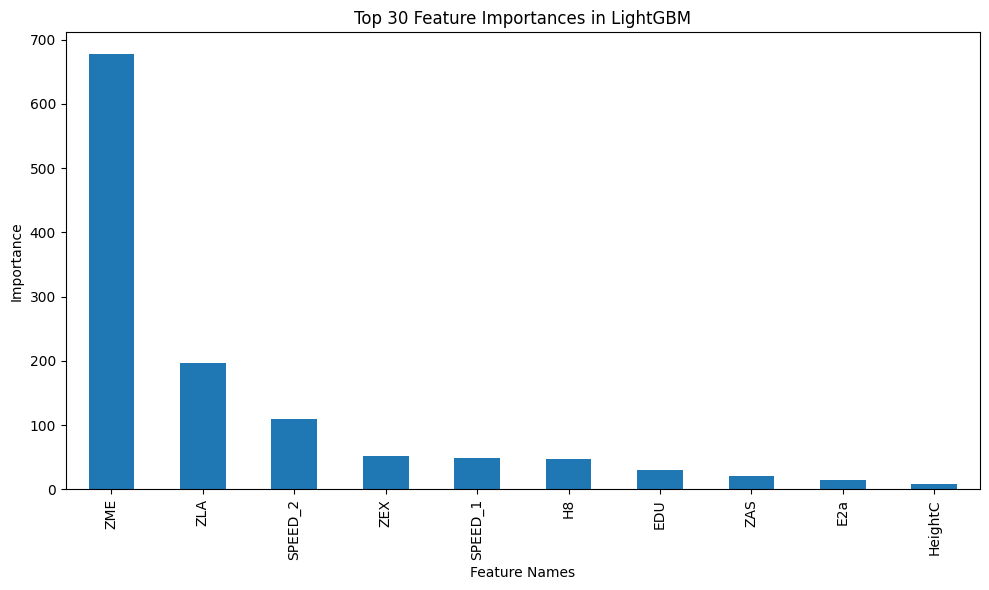

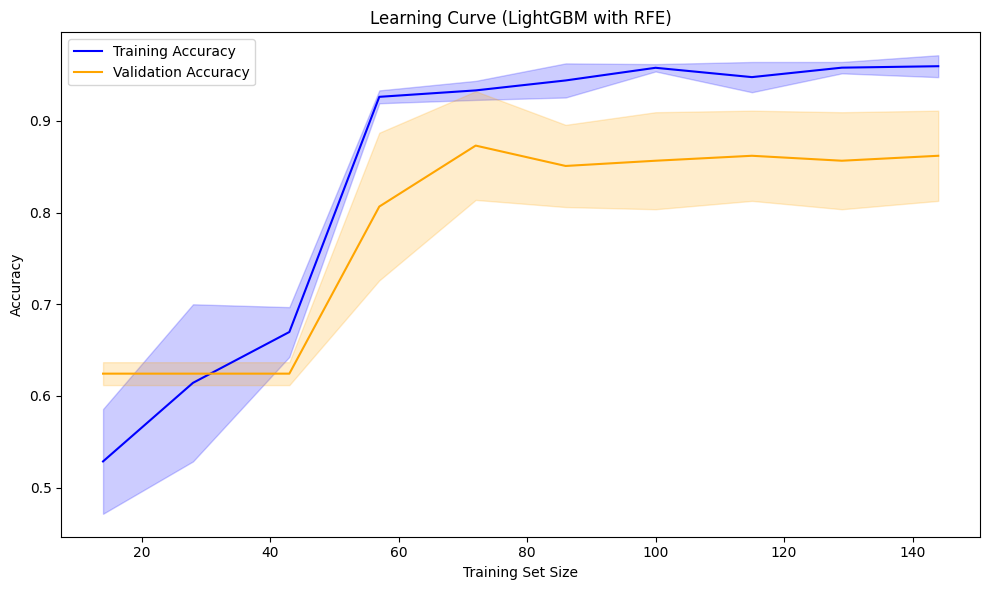

In [43]:
# Prepare LightGBM model for RFE
lgbm_estimator = LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    random_state=random_seed
)

# Set up RFE with LightGBM as the base estimator
rfe_selector = RFE(estimator=lgbm_estimator, n_features_to_select=10, step=1)
rfe_selector = rfe_selector.fit(X_train, y_train)

# Get the mask of selected features
selected_features = rfe_selector.support_
selected_feature_indices = np.where(selected_features)[0]
print(f"Selected features (indices): {selected_feature_indices}")

# Transform the datasets to include only the selected features
X_train_rfe = rfe_selector.transform(X_train)
X_test_rfe = rfe_selector.transform(X_test)

# Define the search space for Hyperopt
space = {
    'num_leaves': scope.int(hp.quniform('num_leaves', 10, 120, 1)),
    'learning_rate': hp.loguniform('learning_rate', -4.5, -1),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 0.9),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 0.9),
    'bagging_freq': scope.int(hp.quniform('bagging_freq', 1, 8, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 30, 1)),
    'lambda_l1': hp.loguniform('lambda_l1', -5, 0),
    'lambda_l2': hp.loguniform('lambda_l2', -5, 0),
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0, 1),
    'num_boost_round': scope.int(hp.quniform('num_boost_round', 50, 300, 10)),
    'verbose': -1,
    'random_state': random_seed
}

# Prepare LightGBM datasets
d_train_rfe = lgb.Dataset(X_train_rfe, label=y_train)
d_valid_rfe = lgb.Dataset(X_test_rfe, label=y_test, reference=d_train_rfe)

# Define the objective function for Hyperopt
def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    num_boost_round = int(params['num_boost_round'])
    del params['num_boost_round']
    
    cv_results = lgb.cv(
        params,
        d_train_rfe,
        num_boost_round=num_boost_round,
        nfold=5,
        stratified=True,
        shuffle=True,
        seed=random_seed,
        metrics='binary_logloss',
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )
    
    logloss_key = 'binary_logloss-mean' if 'binary_logloss-mean' in cv_results else list(cv_results.keys())[0]
    return min(cv_results[logloss_key])

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=8, trials=trials, rstate=np.random.default_rng(random_seed))
print(f"Best hyperparameters: {best}")

# Use the best hyperparameters to train the final model
best_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': int(best['num_leaves']),
    'learning_rate': best['learning_rate'],
    'feature_fraction': best['feature_fraction'],
    'bagging_fraction': best['bagging_fraction'],
    'bagging_freq': int(best['bagging_freq']),
    'max_depth': int(best['max_depth']),
    'lambda_l1': best['lambda_l1'],
    'lambda_l2': best['lambda_l2'],
    'min_gain_to_split': best['min_gain_to_split'],
    'verbose': -1,
    'random_state': random_seed
}

# Train the LightGBM model
evals_result = {}
lgbm_model = lgb.train(
    best_params,
    d_train_rfe,
    num_boost_round=100,
    valid_sets=[d_train_rfe, d_valid_rfe],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=10),
        lgb.record_evaluation(evals_result)
    ]
)

# Make predictions on the test set
lgbm_y_pred_prob_rfe = lgbm_model.predict(X_test_rfe)
lgbm_y_pred_rfe = (lgbm_y_pred_prob_rfe > 0.5).astype(int)

# Evaluate the model on the test set
accuracy_rfe = accuracy_score(y_test, lgbm_y_pred_rfe)
conf_matrix_rfe = confusion_matrix(y_test, lgbm_y_pred_rfe)
class_report_rfe = classification_report(y_test, lgbm_y_pred_rfe)
mcc_rfe = matthews_corrcoef(y_test, lgbm_y_pred_rfe)

print(f"Test Set Accuracy with RFE: {accuracy_rfe}")
print("Test Set Confusion Matrix with RFE:")
print(conf_matrix_rfe)
print("Test Set Classification Report with RFE:")
print(class_report_rfe)
print(f"Test Set MCC with RFE: {mcc_rfe}")

# Plot Feature Importance
importance_df = pd.DataFrame({
    'Feature': [X_train.columns[i] for i in selected_feature_indices],  # Use selected features from RFE
    'Importance': lgbm_model.feature_importance(importance_type='gain')  # You can also use 'split'
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance (LightGBM):")
print(importance_df)

# Plot the top 30 features by importance
plt.figure(figsize=(10, 6))
importance_df[:30].set_index('Feature')['Importance'].plot(kind='bar')
plt.title('Top 30 Feature Importances in LightGBM')
plt.ylabel('Importance')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Generate the learning curve
train_sizes, train_scores, val_scores = learning_curve(
    lgb.LGBMClassifier(**best_params),  # Use best params for LightGBM
    X_train_rfe,                        # Use RFE processed training data
    y_train,                            # Use RFE processed labels
    cv=5,  
    scoring='accuracy',                 # Accuracy metric
    train_sizes=np.linspace(0.1, 1.0, 10),  # Training set sizes (10% to 100%)
    random_state=random_seed,           # Random seed for reproducibility
    n_jobs=-1                           # Use all processors
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation Accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (LightGBM with RFE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# LightGBM + SMOTE

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:                   
[15]	cv_agg's valid binary_logloss: 0.288299 + 0.0778363
Training until validation scores don't improve for 10 rounds                   
Early stopping, best iteration is:                                             
[36]	cv_agg's valid binary_logloss: 0.302412 + 0.0601854
Training until validation scores don't improve for 10 rounds                   
Early stopping, best iteration is:                                             
[31]	cv_agg's valid binary_logloss: 0.28604 + 0.0834321
Training until validation scores don't improve for 10 rounds                   
Did not meet early stopping. Best iteration is:                                
[100]	cv_agg's valid binary_logloss: 0.33462 + 0.0586466
Training until validation scores don't improve for 10 rounds                   
Did not meet early stopping. Best iteration is:                                
[70]	cv_agg's vali

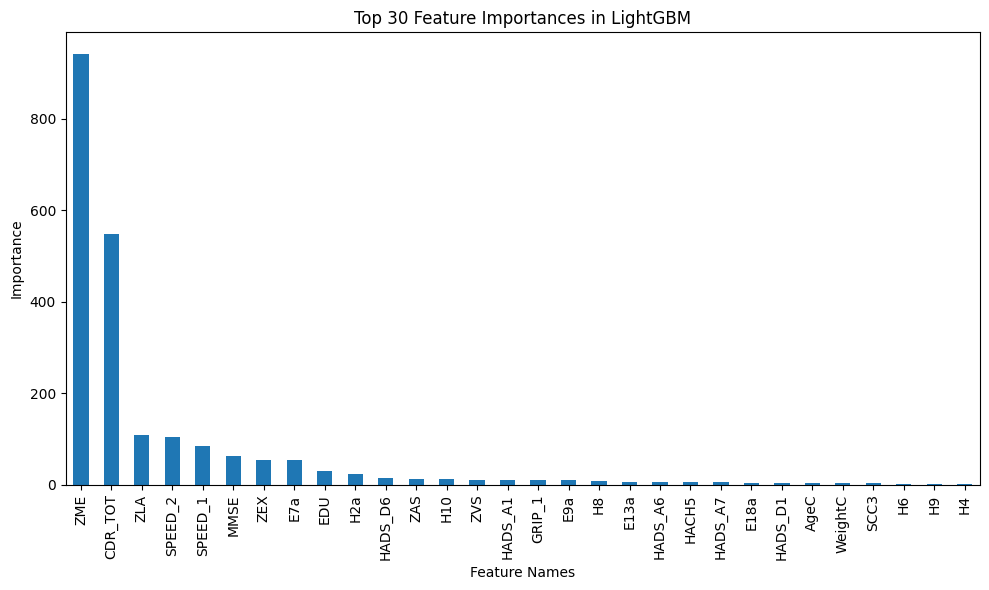

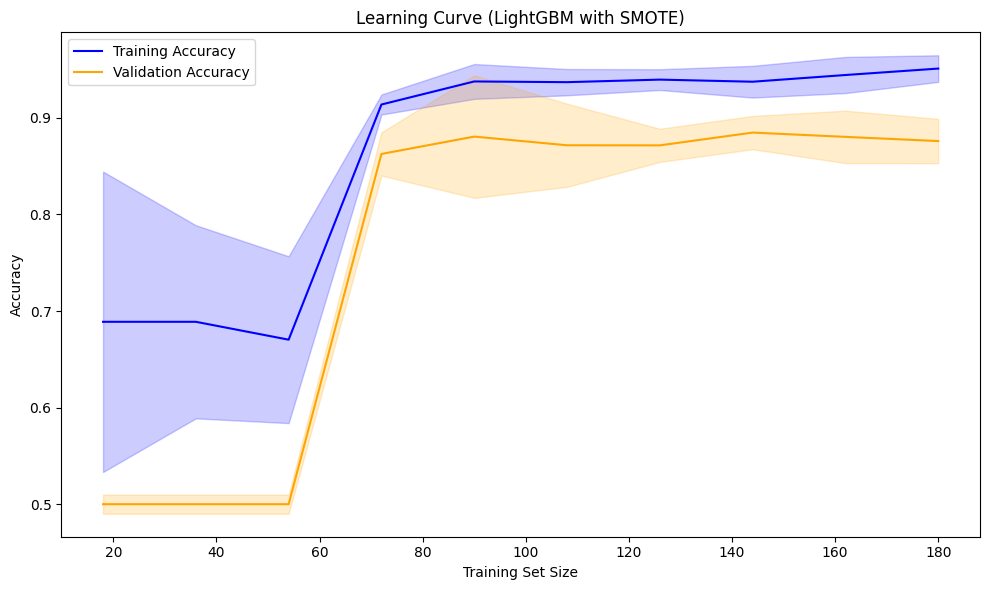

In [44]:
# Apply SMOTE 
smote = SMOTE(random_state=random_seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Define the search space for Hyperopt
space = {
    'num_leaves': scope.int(hp.quniform('num_leaves', 10, 120, 1)),
    'learning_rate': hp.loguniform('learning_rate', -4.5, -1),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 0.9),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 0.9),
    'bagging_freq': scope.int(hp.quniform('bagging_freq', 1, 8, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 30, 1)),
    'lambda_l1': hp.loguniform('lambda_l1', -5, 0),
    'lambda_l2': hp.loguniform('lambda_l2', -5, 0),
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0, 1),
    'num_boost_round': scope.int(hp.quniform('num_boost_round', 50, 300, 10)),
    'verbose': -1,
    'random_state': random_seed
}

# Prepare LightGBM datasets
d_train_smote = lgb.Dataset(X_train_smote, label=y_train_smote)
d_valid = lgb.Dataset(X_test, label=y_test, reference=d_train_smote)

# Define the objective function for Hyperopt
def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    num_boost_round = int(params['num_boost_round'])
    del params['num_boost_round']
    
    cv_results = lgb.cv(
        params,
        d_train_smote,
        num_boost_round=num_boost_round,
        nfold=5,
        stratified=True,
        shuffle=True,
        seed=random_seed,
        metrics='binary_logloss',
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )
    
    logloss_key = 'binary_logloss-mean' if 'binary_logloss-mean' in cv_results else list(cv_results.keys())[0]
    return min(cv_results[logloss_key])

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=8, trials=trials, rstate=np.random.default_rng(random_seed))
print(f"Best hyperparameters: {best}")

# Use the best hyperparameters to train the final model
best_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': int(best['num_leaves']),
    'learning_rate': best['learning_rate'],
    'feature_fraction': best['feature_fraction'],
    'bagging_fraction': best['bagging_fraction'],
    'bagging_freq': int(best['bagging_freq']),
    'max_depth': int(best['max_depth']),
    'lambda_l1': best['lambda_l1'],
    'lambda_l2': best['lambda_l2'],
    'min_gain_to_split': best['min_gain_to_split'],
    'verbose': -1,
    'random_state': random_seed
}

# Train the LightGBM model
evals_result = {}
lgbm_model = lgb.train(
    best_params,
    d_train_smote,
    num_boost_round=100,
    valid_sets=[d_train_smote, d_valid],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=10),
        lgb.record_evaluation(evals_result)
    ]
)

# Make predictions on the test set
lgbm_y_pred_prob = lgbm_model.predict(X_test)
lgbm_y_pred = (lgbm_y_pred_prob > 0.5).astype(int)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, lgbm_y_pred)
conf_matrix = confusion_matrix(y_test, lgbm_y_pred)
class_report = classification_report(y_test, lgbm_y_pred)
mcc = matthews_corrcoef(y_test, lgbm_y_pred)

print(f"Test Set Accuracy: {accuracy}")
print("Test Set Confusion Matrix:")
print(conf_matrix)
print("Test Set Classification Report:")
print(class_report)
print(f"Test Set MCC: {mcc}")

# Plot Feature Importance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgbm_model.feature_importance(importance_type='gain')  # You can also use 'split'
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance (LightGBM):")
print(importance_df)

# Plot the top 30 features by importance
plt.figure(figsize=(10, 6))
importance_df[:30].set_index('Feature')['Importance'].plot(kind='bar')
plt.title('Top 30 Feature Importances in LightGBM')
plt.ylabel('Importance')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Generate the learning curve
train_sizes, train_scores, val_scores = learning_curve(
    lgb.LGBMClassifier(**best_params),  # Use best params for LightGBM
    X_train_smote,                      # Use SMOTE processed training data
    y_train_smote,                      # Use SMOTE processed labels
    cv=5,  
    scoring='accuracy',                 # Accuracy metric
    train_sizes=np.linspace(0.1, 1.0, 10),  # Training set sizes (10% to 100%)
    random_state=random_seed,           # Random seed for reproducibility
    n_jobs=-1                           # Use all processors
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation Accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (LightGBM with SMOTE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# LightGBM + RFE + SMOTE

[LightGBM] [Info] Number of positive: 68, number of negative: 113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 181, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.375691 -> initscore=-0.507880
[LightGBM] [Info] Start training from score -0.507880
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


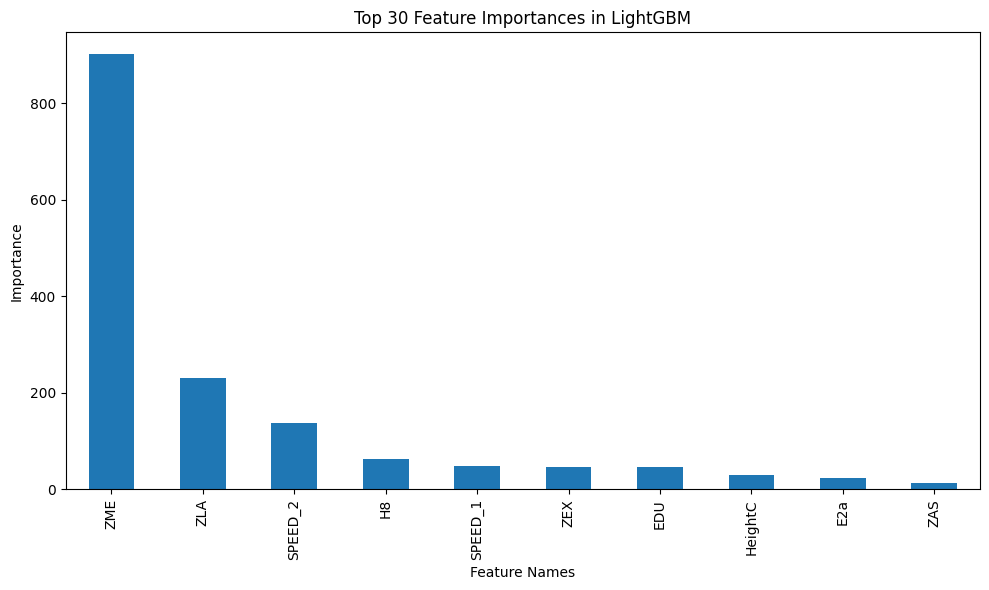

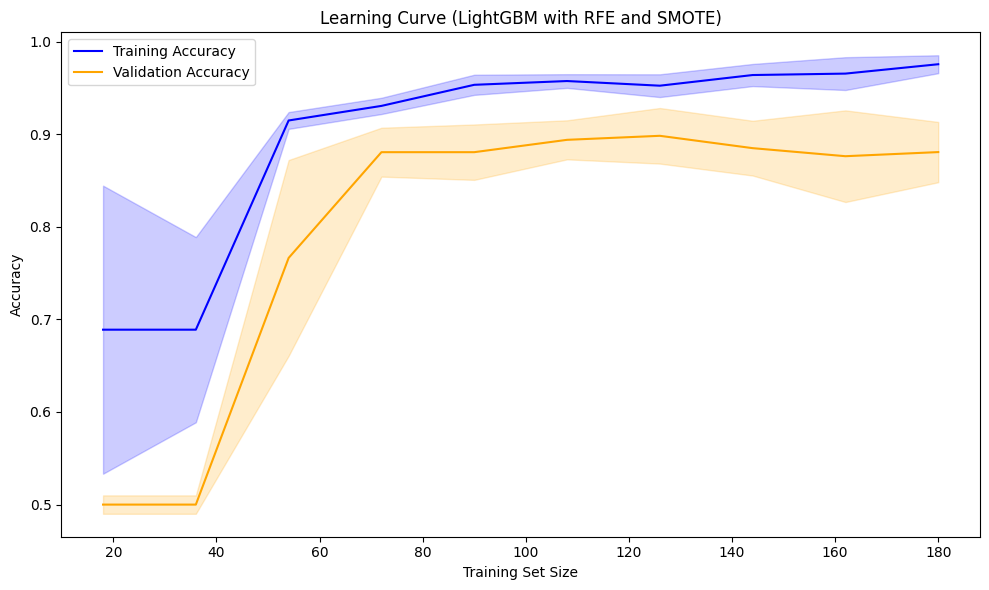

In [45]:
# Prepare LightGBM model for RFE
lgbm_estimator = LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    random_state=random_seed
)

# Set up RFE with LightGBM as the base estimator
rfe_selector = RFE(estimator=lgbm_estimator, n_features_to_select=10, step=1)
rfe_selector = rfe_selector.fit(X_train, y_train)

# Get the mask of selected features
selected_features = rfe_selector.support_
selected_feature_indices = np.where(selected_features)[0]
print(f"Selected features (indices): {selected_feature_indices}")

# Transform the datasets to include only the selected features
X_train_rfe = rfe_selector.transform(X_train)
X_test_rfe = rfe_selector.transform(X_test)

# Apply SMOTE to the RFE-transformed training data
smote = SMOTE(random_state=random_seed)
X_train_rfe_smote, y_train_rfe_smote = smote.fit_resample(X_train_rfe, y_train)

# Define the search space for Hyperopt
space = {
    'num_leaves': scope.int(hp.quniform('num_leaves', 10, 120, 1)),
    'learning_rate': hp.loguniform('learning_rate', -4.5, -1),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 0.9),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 0.9),
    'bagging_freq': scope.int(hp.quniform('bagging_freq', 1, 8, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 30, 1)),
    'lambda_l1': hp.loguniform('lambda_l1', -5, 0),
    'lambda_l2': hp.loguniform('lambda_l2', -5, 0),
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0, 1),
    'num_boost_round': scope.int(hp.quniform('num_boost_round', 50, 300, 10)),
    'verbose': -1,
    'random_state': random_seed
}

# Prepare LightGBM datasets
d_train_rfe_smote = lgb.Dataset(X_train_rfe_smote, label=y_train_rfe_smote)
d_valid_rfe = lgb.Dataset(X_test_rfe, label=y_test, reference=d_train_rfe_smote)

# Define the objective function for Hyperopt
def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    num_boost_round = int(params['num_boost_round'])
    del params['num_boost_round']
    
    cv_results = lgb.cv(
        params,
        d_train_rfe_smote,
        num_boost_round=num_boost_round,
        nfold=5,
        stratified=True,
        shuffle=True,
        seed=random_seed,
        metrics='binary_logloss',
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )
    
    logloss_key = 'binary_logloss-mean' if 'binary_logloss-mean' in cv_results else list(cv_results.keys())[0]
    return min(cv_results[logloss_key])

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=8, trials=trials, rstate=np.random.default_rng(random_seed))
print(f"Best hyperparameters: {best}")

# Use the best hyperparameters to train the final model
best_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': int(best['num_leaves']),
    'learning_rate': best['learning_rate'],
    'feature_fraction': best['feature_fraction'],
    'bagging_fraction': best['bagging_fraction'],
    'bagging_freq': int(best['bagging_freq']),
    'max_depth': int(best['max_depth']),
    'lambda_l1': best['lambda_l1'],
    'lambda_l2': best['lambda_l2'],
    'min_gain_to_split': best['min_gain_to_split'],
    'verbose': -1,
    'random_state': random_seed
}

# Train the LightGBM model
evals_result = {}
lgbm_model = lgb.train(
    best_params,
    d_train_rfe_smote,
    num_boost_round=100,
    valid_sets=[d_train_rfe_smote, d_valid_rfe],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=10),
        lgb.record_evaluation(evals_result)
    ]
)

# Make predictions on the test set
lgbm_y_pred_prob_rfe_smote = lgbm_model.predict(X_test_rfe)
lgbm_y_pred_rfe_smote = (lgbm_y_pred_prob_rfe_smote > 0.5).astype(int)

# Evaluate the model on the test set
accuracy_rfe_smote = accuracy_score(y_test, lgbm_y_pred_rfe_smote)
conf_matrix_rfe_smote = confusion_matrix(y_test, lgbm_y_pred_rfe_smote)
class_report_rfe_smote = classification_report(y_test, lgbm_y_pred_rfe_smote)
mcc_rfe_smote = matthews_corrcoef(y_test, lgbm_y_pred_rfe_smote)

print(f"Test Set Accuracy with RFE and SMOTE: {accuracy_rfe_smote}")
print("Test Set Confusion Matrix with RFE and SMOTE:")
print(conf_matrix_rfe_smote)
print("Test Set Classification Report with RFE and SMOTE:")
print(class_report_rfe_smote)
print(f"Test Set MCC with RFE and SMOTE: {mcc_rfe_smote}")

# Plot Feature Importance
importance_df = pd.DataFrame({
    'Feature': [X_train.columns[i] for i in selected_feature_indices],  # Use selected features from RFE
    'Importance': lgbm_model.feature_importance(importance_type='gain')  # You can also use 'split'
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance (LightGBM):")
print(importance_df)

# Plot the top 30 features by importance
plt.figure(figsize=(10, 6))
importance_df[:30].set_index('Feature')['Importance'].plot(kind='bar')
plt.title('Top 30 Feature Importances in LightGBM')
plt.ylabel('Importance')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Generate the learning curve
train_sizes, train_scores, val_scores = learning_curve(
    lgb.LGBMClassifier(**best_params),  # Use best params for LightGBM
    X_train_rfe_smote,                  # Use RFE + SMOTE processed training data
    y_train_rfe_smote,                  # Use RFE + SMOTE processed labels
    cv=5,  
    scoring='accuracy',                 # Accuracy metric
    train_sizes=np.linspace(0.1, 1.0, 10),  # Training set sizes (10% to 100%)
    random_state=random_seed,           # Random seed for reproducibility
    n_jobs=-1                           # Use all processors
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation Accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (LightGBM with RFE and SMOTE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# XGBOOST

  0%|          | 0/8 [00:00<?, ?trial/s, best loss=?]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 12%|█▎        | 1/8 [00:00<00:03,  2.03trial/s, best loss: -0.8894894894894895]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 25%|██▌       | 2/8 [00:00<00:02,  2.19trial/s, best loss: -0.895045045045045] 

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 38%|███▊      | 3/8 [00:01<00:01,  2.76trial/s, best loss: -0.895045045045045]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 50%|█████     | 4/8 [00:01<00:01,  2.88trial/s, best loss: -0.895045045045045]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 62%|██████▎   | 5/8 [00:01<00:00,  3.17trial/s, best loss: -0.895045045045045]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 75%|███████▌  | 6/8 [00:02<00:00,  3.22trial/s, best loss: -0.895045045045045]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 88%|████████▊ | 7/8 [00:02<00:00,  2.12trial/s, best loss: -0.895045045045045]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

100%|██████████| 8/8 [00:03<00:00,  1.94trial/s, best loss: -0.895045045045045]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 8/8 [00:03<00:00,  2.31trial/s, best loss: -0.895045045045045]
Best hyperparameters: {'colsample_bytree': np.float64(0.6315933119342986), 'eta': np.float64(0.11309157989114597), 'max_depth': np.float64(8.0), 'min_child_weight': np.float64(9.0), 'n_estimators': np.float64(320.0), 'subsample': np.float64(0.7201685419162033)}
[0]	validation_0-logloss:0.61690
[1]	validation_0-logloss:0.58876
[2]	validation_0-logloss:0.53853
[3]	validation_0-logloss:0.50494
[4]	validation_0-logloss:0.48817
[5]	validation_0-logloss:0.45436
[6]	validation_0-logloss:0.43203
[7]	validation_0-logloss:0.40413
[8]	validation_0-logloss:0.38302
[9]	validation_0-logloss:0.36618
[10]	validation_0-logloss:0.34662
[11]	validation_0-logloss:0.33014
[12]	validation_0-logloss:0.32908
[13]	validation_0-logloss:0.31881
[14]	validation_0-logloss:0.30905
[15]	validation_0-logloss:0.30880
[16]	validation_0-logloss:0.30013
[17]	validation_0-logloss:0.30009
[18]	validation_0-logloss:0.30040
[19]	validation_0-logl

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


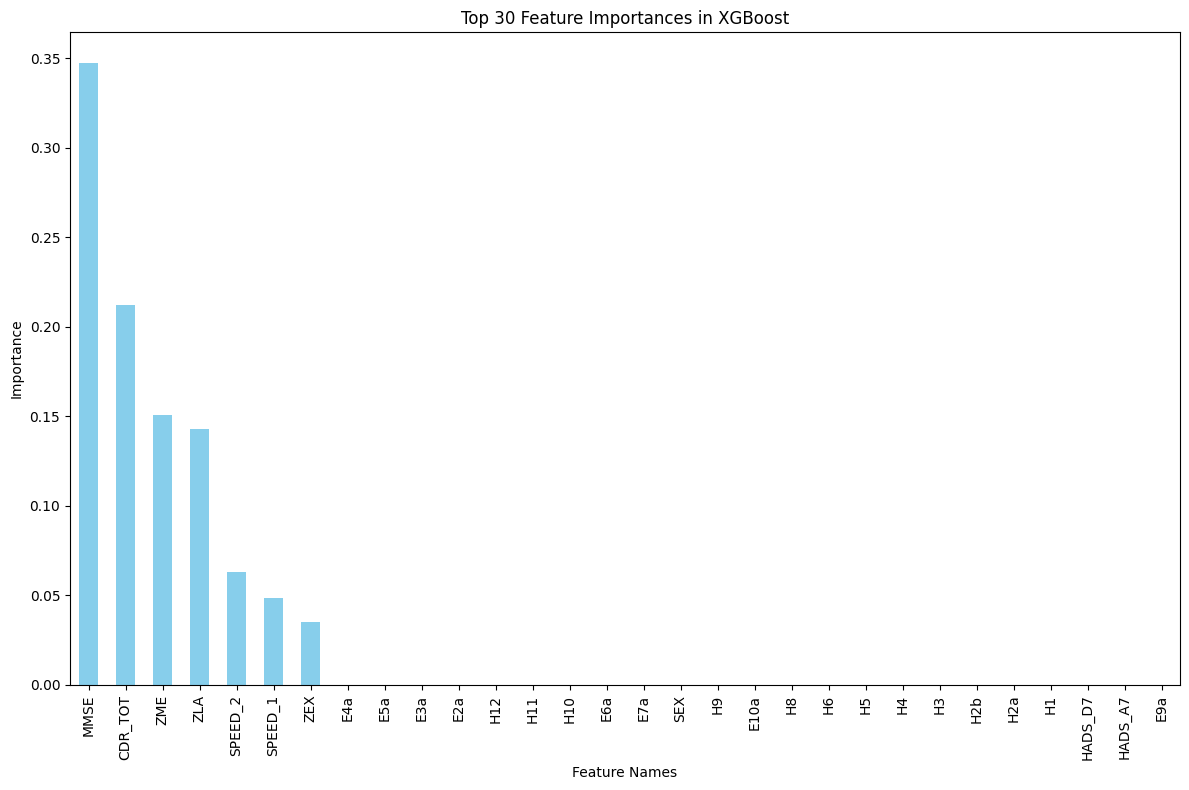

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_e

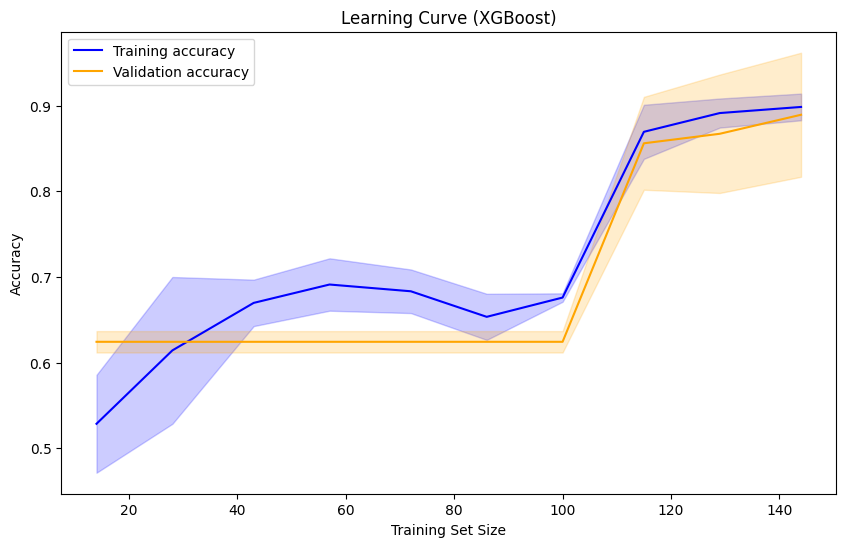

In [46]:
# Define the objective function for Hyperopt
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['n_estimators'] = int(params['n_estimators'])

    model = XGBClassifier(
        **params,
        use_label_encoder=False,
        random_state=random_seed,
        verbosity=1
    )
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return -np.mean(scores)

# Define the search space for XGBClassifier parameters
space = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': hp.loguniform('eta', -5, 0),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 50, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),
}

# Run the optimization with Hyperopt
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=8, trials=trials, rstate=np.random.default_rng(random_seed))

print(f"Best hyperparameters: {best}")

# Convert the best params for training
best_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': best['eta'],
    'max_depth': int(best['max_depth']),
    'min_child_weight': int(best['min_child_weight']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'n_estimators': int(best['n_estimators']),
    'random_state': random_seed,
    'use_label_encoder': False,
    'early_stopping_rounds': 10,
}

# Train the model
model_all_visits = XGBClassifier(**best_params)
model_all_visits.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

# Make predictions
y_pred_prob_model_all_visits = model_all_visits.predict_proba(X_test)[:, 1]
y_pred_model_all_visits = (y_pred_prob_model_all_visits > 0.5).astype(int)

# Evaluate the model
accuracy_model_all_visits = accuracy_score(y_test, y_pred_model_all_visits)
conf_matrix_model_all_visits = confusion_matrix(y_test, y_pred_model_all_visits)
class_report_model_all_visits = classification_report(y_test, y_pred_model_all_visits)
mcc_model_all_visits = matthews_corrcoef(y_test, y_pred_model_all_visits)

print(f"Test Set Accuracy: {accuracy_model_all_visits}")
print("Test Set Confusion Matrix:")
print(conf_matrix_model_all_visits)
print("Test Set Classification Report:")
print(class_report_model_all_visits)
print(f"Test Set MCC: {mcc_model_all_visits}")

# Feature importance analysis
feature_importances_model_all_visits = model_all_visits.feature_importances_
feature_names_model_all_visits = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances_model_all_visits = pd.Series(feature_importances_model_all_visits, index=feature_names_model_all_visits)
feat_importances_model_all_visits = feat_importances_model_all_visits.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(12, 8))
feat_importances_model_all_visits[:30].plot(kind='bar', color='skyblue')
plt.title('Top 30 Feature Importances in XGBoost')
plt.ylabel('Importance')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Remove `early_stopping_rounds` for the learning curve
params_for_learning_curve_model_all_visits = {key: value for key, value in best_params.items() if key != 'early_stopping_rounds'}

# Generate the learning curve
train_sizes_model_all_visits, train_scores_model_all_visits, val_scores_model_all_visits = learning_curve(
    XGBClassifier(**params_for_learning_curve_model_all_visits),
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=random_seed
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores_model_all_visits, axis=1)
train_scores_std = np.std(train_scores_model_all_visits, axis=1)
val_scores_mean = np.mean(val_scores_model_all_visits, axis=1)
val_scores_std = np.std(val_scores_model_all_visits, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_model_all_visits, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes_model_all_visits, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes_model_all_visits, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes_model_all_visits, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (XGBoost)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# XGBOOST + RFE

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_e

Selected features: ['EDU', 'ΜaritalC', 'MH10', 'MED5', 'MED11', 'MED12', 'MED13', 'NPI11', 'CDR_TOT', 'MMSE', 'ZME', 'ZEX', 'ZLA', 'ZAS', 'HADS_A1', 'HADS_A2', 'HADS_D4', 'HADS_D6', 'H3', 'H6', 'H8', 'H10', 'E4a', 'E6a', 'E7a', 'E11a', 'E18a', 'E20a', 'SPEED_1', 'SPEED_2']
  0%|          | 0/8 [00:00<?, ?trial/s, best loss=?]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_e

 12%|█▎        | 1/8 [00:00<00:01,  4.30trial/s, best loss: -0.8839339339339339]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 25%|██▌       | 2/8 [00:00<00:01,  4.43trial/s, best loss: -0.8894894894894895]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 38%|███▊      | 3/8 [00:00<00:00,  5.94trial/s, best loss: -0.8894894894894895]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 62%|██████▎   | 5/8 [00:00<00:00,  6.26trial/s, best loss: -0.8894894894894895]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 75%|███████▌  | 6/8 [00:00<00:00,  6.78trial/s, best loss: -0.8894894894894895]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 88%|████████▊ | 7/8 [00:01<00:00,  4.10trial/s, best loss: -0.8894894894894895]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

100%|██████████| 8/8 [00:01<00:00,  4.58trial/s, best loss: -0.8894894894894895]
Best hyperparameters: {'colsample_bytree': np.float64(0.6315933119342986), 'eta': np.float64(0.11309157989114597), 'max_depth': np.float64(8.0), 'min_child_weight': np.float64(9.0), 'n_estimators': np.float64(320.0), 'subsample': np.float64(0.7201685419162033)}
[0]	validation_0-logloss:0.58635
[1]	validation_0-logloss:0.53504
[2]	validation_0-logloss:0.49543
[3]	validation_0-logloss:0.46719
[4]	validation_0-logloss:0.43836
[5]	validation_0-logloss:0.41367
[6]	validation_0-logloss:0.39712
[7]	validation_0-logloss:0.37591
[8]	validation_0-logloss:0.36067
[9]	validation_0-logloss:0.34669
[10]	validation_0-logloss:0.33382
[11]	validation_0-logloss:0.31896
[12]	validation_0-logloss:0.31838
[13]	validation_0-logloss:0.30932
[14]	validation_0-logloss:0.30094
[15]	validation_0-logloss:0.29278
[16]	validation_0-logloss:0.29035
[17]	validation_0-logloss:0.29027
[18]	validation_0-logloss:0.28755
[19]	validation_0-log

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


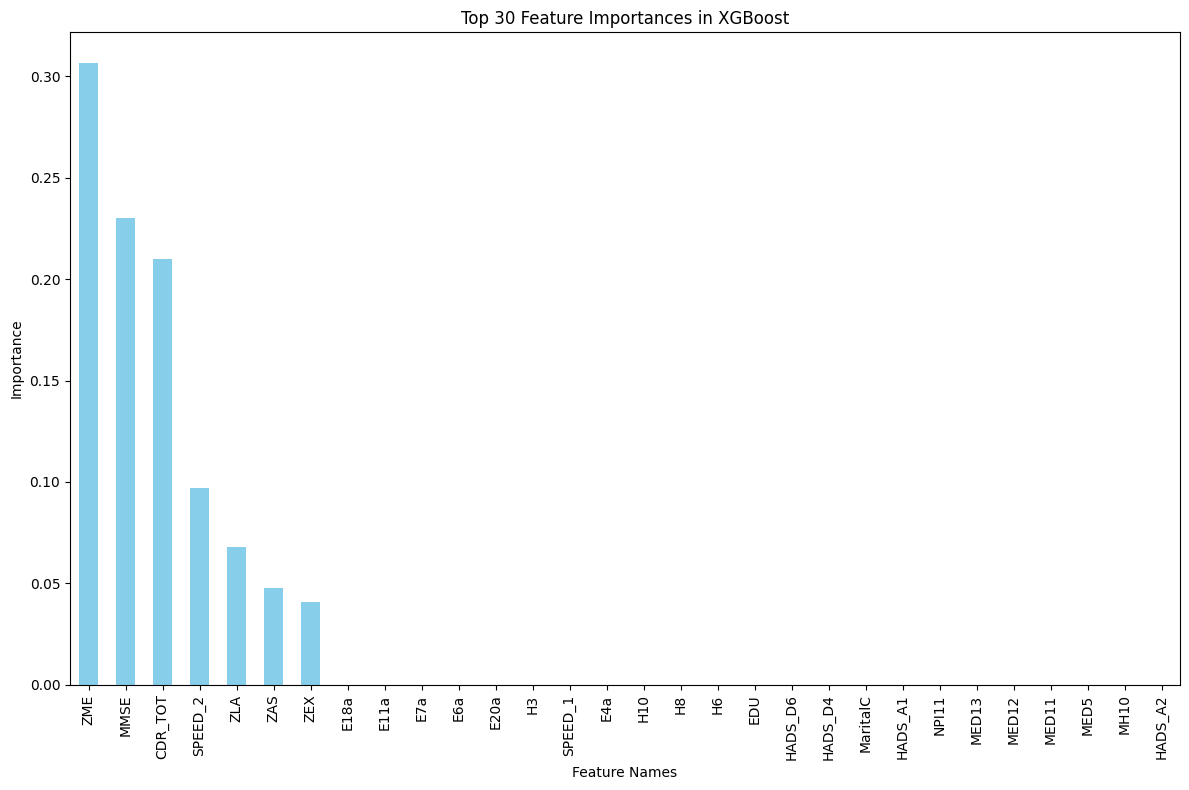

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_e

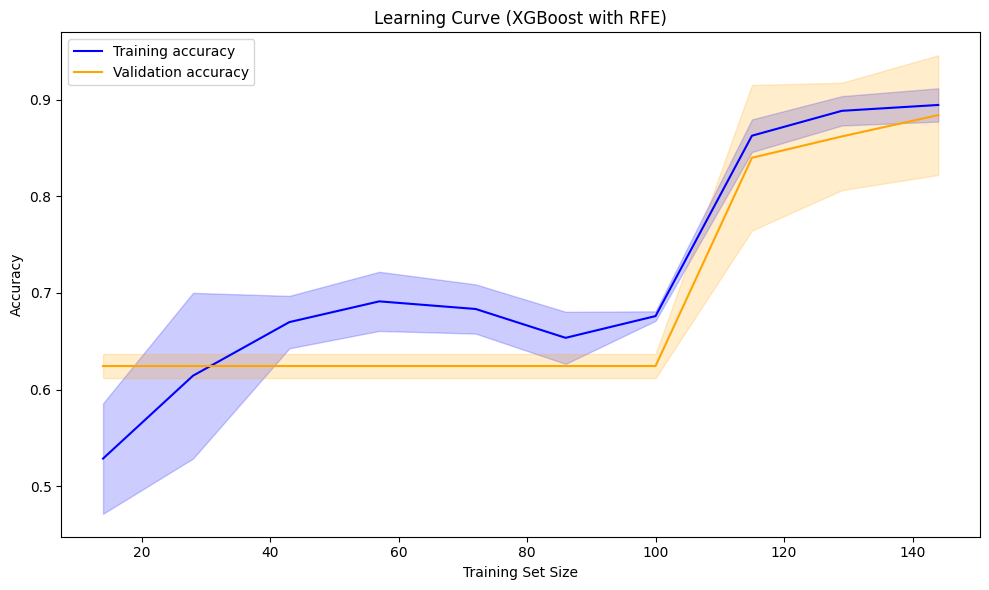

In [50]:
# Feature selection with RFE
base_model = XGBClassifier(random_state=random_seed, use_label_encoder=False)
rfe = RFE(estimator=base_model, n_features_to_select=30, step=1) 
rfe.fit(X_train, y_train)

# Update training and test sets with selected features
X_train_rfe = X_train.iloc[:, rfe.support_]
X_test_rfe = X_test.iloc[:, rfe.support_]

print(f"Selected features: {list(X_train_rfe.columns)}")

# Define the objective function for Hyperopt
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['n_estimators'] = int(params['n_estimators'])

    model = XGBClassifier(
        **params,
        use_label_encoder=False,
        random_state=random_seed,
        verbosity=1
    )
    # Perform cross-validation
    scores = cross_val_score(model, X_train_rfe, y_train, cv=5, scoring='accuracy')
    return -np.mean(scores)

# Define the search space for XGBClassifier parameters
space = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': hp.loguniform('eta', -5, 0),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 50, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),
}

# Run the optimization with Hyperopt
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=8, trials=trials, rstate=np.random.default_rng(random_seed))

print(f"Best hyperparameters: {best}")

# Convert the best params for training
best_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': best['eta'],
    'max_depth': int(best['max_depth']),
    'min_child_weight': int(best['min_child_weight']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'n_estimators': int(best['n_estimators']),
    'random_state': random_seed,
    'use_label_encoder': False,
    'early_stopping_rounds': 10,
}

# Train the model
model_all_visits = XGBClassifier(**best_params)
model_all_visits.fit(X_train_rfe, y_train, eval_set=[(X_test_rfe, y_test)], verbose=True)

# Make predictions
y_pred_prob_model_all_visits = model_all_visits.predict_proba(X_test_rfe)[:, 1]
y_pred_model_all_visits = (y_pred_prob_model_all_visits > 0.5).astype(int)

# Evaluate the model
accuracy_model_all_visits = accuracy_score(y_test, y_pred_model_all_visits)
conf_matrix_model_all_visits = confusion_matrix(y_test, y_pred_model_all_visits)
class_report_model_all_visits = classification_report(y_test, y_pred_model_all_visits)
mcc_model_all_visits = matthews_corrcoef(y_test, y_pred_model_all_visits)

print(f"Test Set Accuracy: {accuracy_model_all_visits}")
print("Test Set Confusion Matrix:")
print(conf_matrix_model_all_visits)
print("Test Set Classification Report:")
print(class_report_model_all_visits)
print(f"Test Set MCC: {mcc_model_all_visits}")

# Feature importance analysis
feature_importances_model_all_visits = model_all_visits.feature_importances_
feature_names_model_all_visits = X_train_rfe.columns
feat_importances_model_all_visits = pd.Series(feature_importances_model_all_visits, index=feature_names_model_all_visits)
feat_importances_model_all_visits = feat_importances_model_all_visits.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(12, 8))
feat_importances_model_all_visits[:30].plot(kind='bar', color='skyblue')
plt.title('Top 30 Feature Importances in XGBoost')
plt.ylabel('Importance')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Remove `early_stopping_rounds` for the learning curve
params_for_learning_curve_model_all_visits = {key: value for key, value in best_params.items() if key != 'early_stopping_rounds'}

# Generate the learning curve
train_sizes_model_all_visits, train_scores_model_all_visits, val_scores_model_all_visits = learning_curve(
    XGBClassifier(**params_for_learning_curve_model_all_visits),
    X_train_rfe,
    y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=random_seed
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores_model_all_visits, axis=1)
train_scores_std = np.std(train_scores_model_all_visits, axis=1)
val_scores_mean = np.mean(val_scores_model_all_visits, axis=1)
val_scores_std = np.std(val_scores_model_all_visits, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_model_all_visits, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes_model_all_visits, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes_model_all_visits, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes_model_all_visits, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (XGBoost with RFE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()



# XGBOOST + SMOTE

  0%|          | 0/8 [00:00<?, ?trial/s, best loss=?]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 12%|█▎        | 1/8 [00:00<00:03,  1.91trial/s, best loss: -0.8670531400966184]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 25%|██▌       | 2/8 [00:00<00:02,  2.12trial/s, best loss: -0.8760386473429952]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 38%|███▊      | 3/8 [00:01<00:01,  2.78trial/s, best loss: -0.8760386473429952]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 50%|█████     | 4/8 [00:01<00:01,  2.61trial/s, best loss: -0.8760386473429952]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 62%|██████▎   | 5/8 [00:01<00:01,  2.88trial/s, best loss: -0.8760386473429952]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 75%|███████▌  | 6/8 [00:02<00:00,  3.09trial/s, best loss: -0.8760386473429953]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 88%|████████▊ | 7/8 [00:02<00:00,  2.10trial/s, best loss: -0.9025120772946862]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

100%|██████████| 8/8 [00:03<00:00,  2.25trial/s, best loss: -0.9025120772946862]
Best hyperparameters: {'colsample_bytree': np.float64(0.9790830954612103), 'eta': np.float64(0.08467406425814078), 'max_depth': np.float64(44.0), 'min_child_weight': np.float64(2.0), 'n_estimators': np.float64(500.0), 'subsample': np.float64(0.8796314378966033)}
[0]	validation_0-logloss:0.63930
[1]	validation_0-logloss:0.59673
[2]	validation_0-logloss:0.56093
[3]	validation_0-logloss:0.52925
[4]	validation_0-logloss:0.50229
[5]	validation_0-logloss:0.47900
[6]	validation_0-logloss:0.45818
[7]	validation_0-logloss:0.44332
[8]	validation_0-logloss:0.42866
[9]	validation_0-logloss:0.41576
[10]	validation_0-logloss:0.40197
[11]	validation_0-logloss:0.38558
[12]	validation_0-logloss:0.37342
[13]	validation_0-logloss:0.36562
[14]	validation_0-logloss:0.35862
[15]	validation_0-logloss:0.35047
[16]	validation_0-logloss:0.34264
[17]	validation_0-logloss:0.33521
[18]	validation_0-logloss:0.32939
[19]	validation_0-lo

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


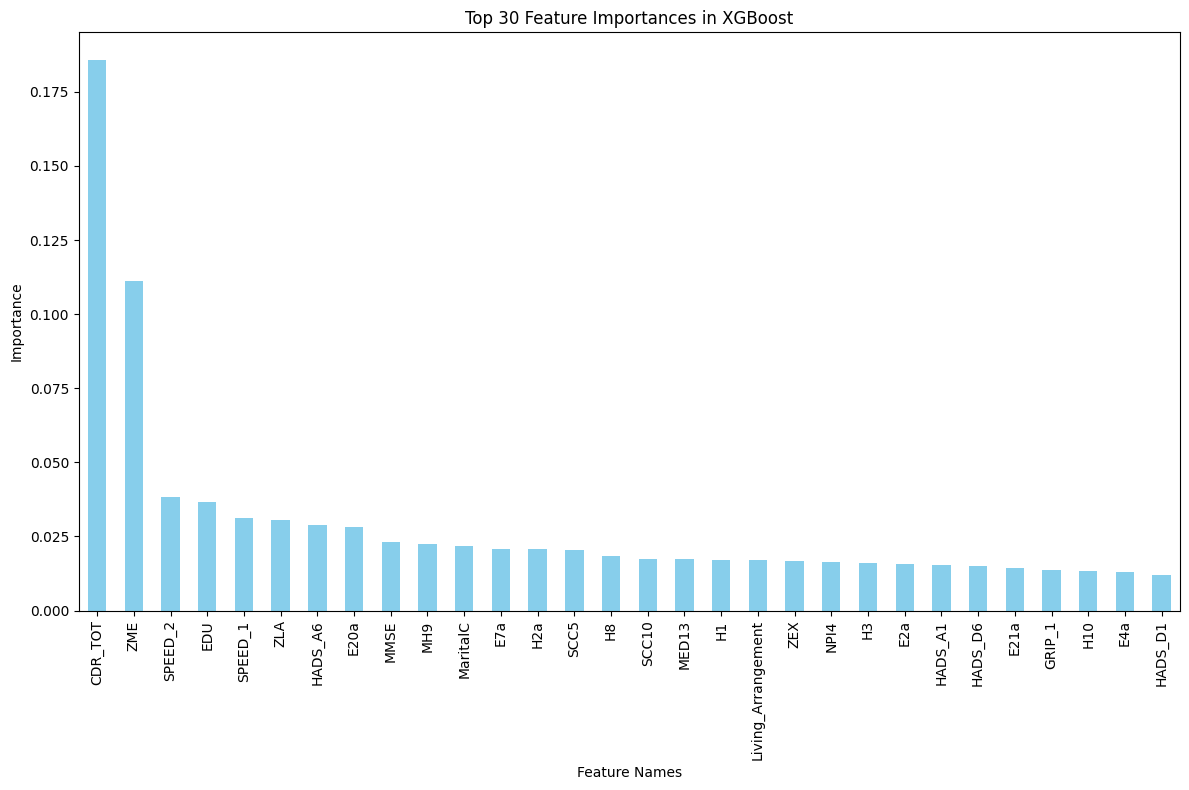

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_e

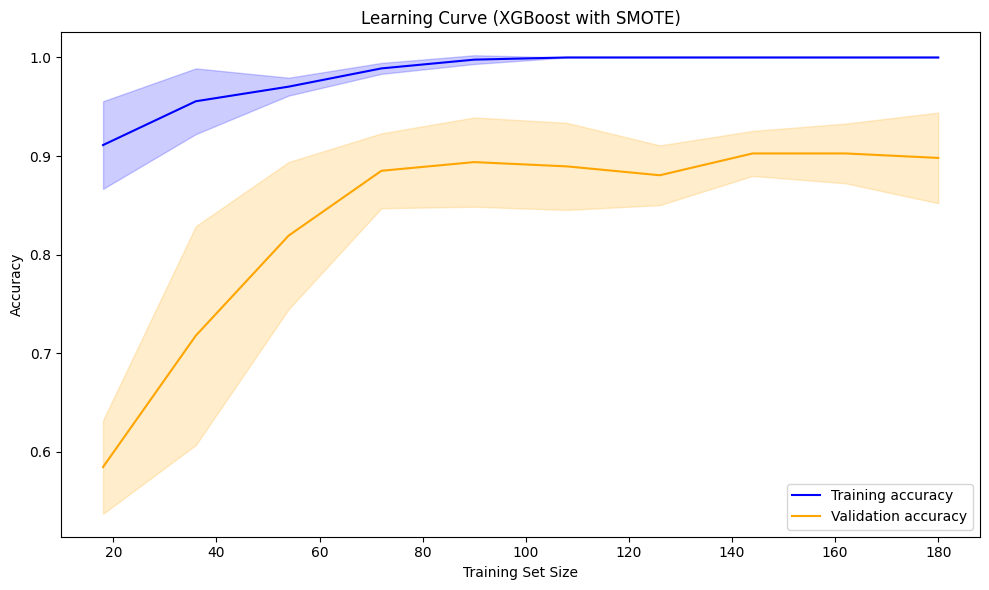

In [51]:
# Apply SMOTE 
smote = SMOTE(random_state=random_seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Define the objective function for Hyperopt
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['n_estimators'] = int(params['n_estimators'])

    model = XGBClassifier(
        **params,
        use_label_encoder=False,
        random_state=random_seed,
        verbosity=1
    )
    # Perform cross-validation
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring='accuracy')
    return -np.mean(scores)

# Define the search space for XGBClassifier parameters
space = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': hp.loguniform('eta', -5, 0),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 50, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),
}

# Run the optimization with Hyperopt
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=8, trials=trials, rstate=np.random.default_rng(random_seed))

print(f"Best hyperparameters: {best}")

# Convert the best params for training
best_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': best['eta'],
    'max_depth': int(best['max_depth']),
    'min_child_weight': int(best['min_child_weight']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'n_estimators': int(best['n_estimators']),
    'random_state': random_seed,
    'use_label_encoder': False,
    'early_stopping_rounds': 10,
}

# Train the model
model_all_visits = XGBClassifier(**best_params)
model_all_visits.fit(X_train_smote, y_train_smote, eval_set=[(X_test, y_test)], verbose=True)

# Make predictions
y_pred_prob_model_all_visits = model_all_visits.predict_proba(X_test)[:, 1]
y_pred_model_all_visits = (y_pred_prob_model_all_visits > 0.5).astype(int)

# Evaluate the model
accuracy_model_all_visits = accuracy_score(y_test, y_pred_model_all_visits)
conf_matrix_model_all_visits = confusion_matrix(y_test, y_pred_model_all_visits)
class_report_model_all_visits = classification_report(y_test, y_pred_model_all_visits)
mcc_model_all_visits = matthews_corrcoef(y_test, y_pred_model_all_visits)

print(f"Test Set Accuracy: {accuracy_model_all_visits}")
print("Test Set Confusion Matrix:")
print(conf_matrix_model_all_visits)
print("Test Set Classification Report:")
print(class_report_model_all_visits)
print(f"Test Set MCC: {mcc_model_all_visits}")

# Feature importance analysis
feature_importances_model_all_visits = model_all_visits.feature_importances_
feature_names_model_all_visits = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances_model_all_visits = pd.Series(feature_importances_model_all_visits, index=feature_names_model_all_visits)
feat_importances_model_all_visits = feat_importances_model_all_visits.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(12, 8))
feat_importances_model_all_visits[:30].plot(kind='bar', color='skyblue')
plt.title('Top 30 Feature Importances in XGBoost')
plt.ylabel('Importance')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Remove `early_stopping_rounds` for the learning curve
params_for_learning_curve_model_all_visits = {key: value for key, value in best_params.items() if key != 'early_stopping_rounds'}

# Generate the learning curve
train_sizes_model_all_visits, train_scores_model_all_visits, val_scores_model_all_visits = learning_curve(
    XGBClassifier(**params_for_learning_curve_model_all_visits),
    X_train_smote,
    y_train_smote,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=random_seed
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores_model_all_visits, axis=1)
train_scores_std = np.std(train_scores_model_all_visits, axis=1)
val_scores_mean = np.mean(val_scores_model_all_visits, axis=1)
val_scores_std = np.std(val_scores_model_all_visits, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_model_all_visits, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes_model_all_visits, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes_model_all_visits, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes_model_all_visits, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (XGBoost with SMOTE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# XGBOOST + RFE + SMOTE

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_e

Selected features: ['EDU', 'ΜaritalC', 'MH10', 'MED5', 'MED11', 'MED12', 'MED13', 'NPI11', 'CDR_TOT', 'MMSE', 'ZME', 'ZEX', 'ZLA', 'ZAS', 'HADS_A1', 'HADS_A2', 'HADS_D4', 'HADS_D6', 'H3', 'H6', 'H8', 'H10', 'E4a', 'E6a', 'E7a', 'E11a', 'E18a', 'E20a', 'SPEED_1', 'SPEED_2']
  0%|          | 0/8 [00:00<?, ?trial/s, best loss=?]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_e

 12%|█▎        | 1/8 [00:00<00:02,  2.42trial/s, best loss: -0.8714975845410627]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 38%|███▊      | 3/8 [00:00<00:01,  4.57trial/s, best loss: -0.8892753623188405]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 50%|█████     | 4/8 [00:00<00:00,  4.77trial/s, best loss: -0.8892753623188405]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 75%|███████▌  | 6/8 [00:01<00:00,  6.06trial/s, best loss: -0.9026086956521739]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 88%|████████▊ | 7/8 [00:01<00:00,  3.75trial/s, best loss: -0.9026086956521739]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 8/8 [00:02<00:00,  3.95trial/s, best loss: -0.9026086956521739]
Best hyperparameters: {'colsample_bytree': np.float64(0.825233769951204), 'eta': np.float64(0.6266945394807835), 'max_depth': np.float64(38.0), 'min_child_weight': np.float64(5.0), 'n_estimators': np.float64(120.0), 'subsample': np.float64(0.9018909441059156)}
[0]	validation_0-logloss:0.42212
[1]	validation_0-logloss:0.33848
[2]	validation_0-logloss:0.30646
[3]	validation_0-logloss:0.28874


/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

[4]	validation_0-logloss:0.26784
[5]	validation_0-logloss:0.28553
[6]	validation_0-logloss:0.27606
[7]	validation_0-logloss:0.28663
[8]	validation_0-logloss:0.30360
[9]	validation_0-logloss:0.30874
[10]	validation_0-logloss:0.30031
[11]	validation_0-logloss:0.29606
[12]	validation_0-logloss:0.30086
[13]	validation_0-logloss:0.29834
[14]	validation_0-logloss:0.30716
Test Set Accuracy: 0.8958333333333334
Test Set Confusion Matrix:
[[27  4]
 [ 1 16]]
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.92        31
           1       0.80      0.94      0.86        17

    accuracy                           0.90        48
   macro avg       0.88      0.91      0.89        48
weighted avg       0.91      0.90      0.90        48

Test Set MCC: 0.7878516482001543


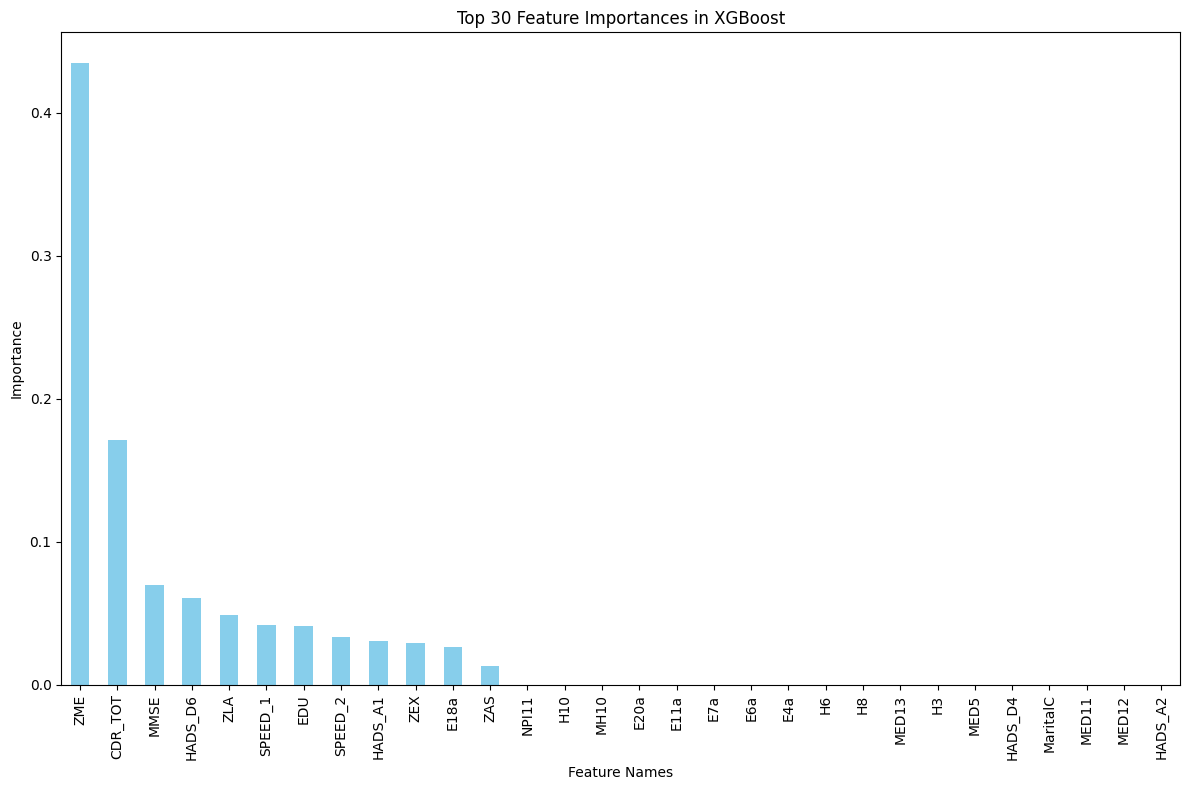

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:04:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_e

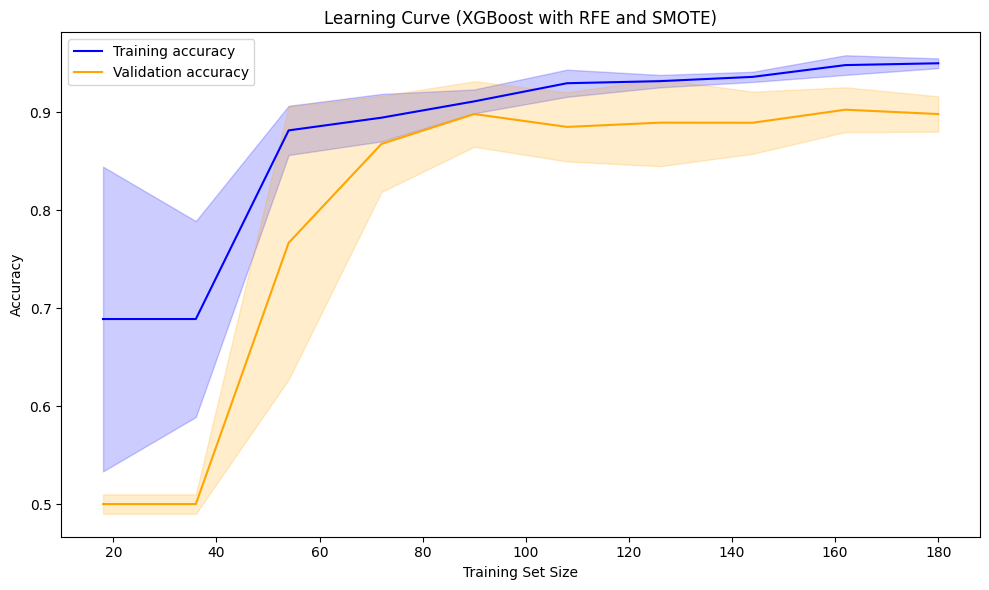

In [52]:
# Apply RFE 
base_model = XGBClassifier(random_state=random_seed, use_label_encoder=False)
rfe = RFE(estimator=base_model, n_features_to_select=30, step=1) 
rfe.fit(X_train, y_train)

# Update training and test sets with selected features
X_train_rfe = X_train.iloc[:, rfe.support_]
X_test_rfe = X_test.iloc[:, rfe.support_]

print(f"Selected features: {list(X_train_rfe.columns)}")

# Apply SMOTE 
smote = SMOTE(random_state=random_seed)
X_train_rfe_smote, y_train_smote = smote.fit_resample(X_train_rfe, y_train)

# Define the objective function for Hyperopt
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['n_estimators'] = int(params['n_estimators'])

    model = XGBClassifier(
        **params,
        use_label_encoder=False,
        random_state=random_seed,
        verbosity=1
    )
    # Perform cross-validation
    scores = cross_val_score(model, X_train_rfe_smote, y_train_smote, cv=5, scoring='accuracy')
    return -np.mean(scores)

# Define the search space for XGBClassifier parameters
space = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': hp.loguniform('eta', -5, 0),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 50, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),
}

# Run the optimization with Hyperopt
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=8, trials=trials, rstate=np.random.default_rng(random_seed))

print(f"Best hyperparameters: {best}")

# Convert the best params for training
best_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': best['eta'],
    'max_depth': int(best['max_depth']),
    'min_child_weight': int(best['min_child_weight']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'n_estimators': int(best['n_estimators']),
    'random_state': random_seed,
    'use_label_encoder': False,
    'early_stopping_rounds': 10,
}

# Train the model
model_all_visits = XGBClassifier(**best_params)
model_all_visits.fit(X_train_rfe_smote, y_train_smote, eval_set=[(X_test_rfe, y_test)], verbose=True)

# Make predictions
y_pred_prob_model_all_visits = model_all_visits.predict_proba(X_test_rfe)[:, 1]
y_pred_model_all_visits = (y_pred_prob_model_all_visits > 0.5).astype(int)

# Evaluate the model
accuracy_model_all_visits = accuracy_score(y_test, y_pred_model_all_visits)
conf_matrix_model_all_visits = confusion_matrix(y_test, y_pred_model_all_visits)
class_report_model_all_visits = classification_report(y_test, y_pred_model_all_visits)
mcc_model_all_visits = matthews_corrcoef(y_test, y_pred_model_all_visits)

print(f"Test Set Accuracy: {accuracy_model_all_visits}")
print("Test Set Confusion Matrix:")
print(conf_matrix_model_all_visits)
print("Test Set Classification Report:")
print(class_report_model_all_visits)
print(f"Test Set MCC: {mcc_model_all_visits}")

# Feature importance 
feature_importances_model_all_visits = model_all_visits.feature_importances_
feature_names_model_all_visits = X_train_rfe.columns
feat_importances_model_all_visits = pd.Series(feature_importances_model_all_visits, index=feature_names_model_all_visits)
feat_importances_model_all_visits = feat_importances_model_all_visits.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(12, 8))
feat_importances_model_all_visits[:30].plot(kind='bar', color='skyblue')
plt.title('Top 30 Feature Importances in XGBoost')
plt.ylabel('Importance')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Learning curve
params_for_learning_curve_model_all_visits = {key: value for key, value in best_params.items() if key != 'early_stopping_rounds'}

train_sizes_model_all_visits, train_scores_model_all_visits, val_scores_model_all_visits = learning_curve(
    XGBClassifier(**params_for_learning_curve_model_all_visits),
    X_train_rfe_smote,
    y_train_smote,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=random_seed
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores_model_all_visits, axis=1)
train_scores_std = np.std(train_scores_model_all_visits, axis=1)
val_scores_mean = np.mean(val_scores_model_all_visits, axis=1)
val_scores_std = np.std(val_scores_model_all_visits, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_model_all_visits, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes_model_all_visits, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes_model_all_visits, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes_model_all_visits, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (XGBoost with RFE and SMOTE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
